# CS536 Homework Assignment #1

In this homework, we will implement a few core CNN blocks and practice training neural networks by following the guidance step by step. The model to implement is similar to the [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). To do this some implementation sketch will be provided on which you can fill in your implementation.

In the following, we first import the basic packages. Feel free to add other packages if necessary.
**Note**: The only allowed deep learning framework is PyTorch. Please use Python 3.6 or newer verions and PyTorch 1.3 or newer verions for this homework.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

The following is a sketch of the LeNet class which you will be filling in step-by-step. For now, you don't need to do anything with the following code.

In [2]:
# LeNet sketch code
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    """
    self.c1 = Conv2D()
    self.p2 = nn.AvgPool(2, stride=2)
    self.c3 = Conv2D()
    self.p4 = nn.AvgPool(2, stride=2)
    self.c5 = Linear()
    self.f6 = Linear()
    """
    
    
  def forward(self, imgs, labels):
    """
    scores = self.net(imgs)
    o = softmax(scores)
    loss = objective(o, labels)
    """
    return loss

## Task 1: Implement Convolutional Layer

The first task is to implement a convolutional layer by completing the following Conv2D class. The class takes the number of input channels, the number of output channels, stride size, and padding values as inputs. 

**To-do**:
    - (10 points)Implement code in-between (### start your code here ### and ### End of the code ###)

In [3]:
class Conv2D(nn.Module):
  def __init__(self, dim_in, dim_out, kernel_size, stride, padding, device):
    super(Conv2D, self).__init__()
    """
    inputs:
      dim_in: integer, number of channels in the input
      dim_out: integer, number of channels produced by the convolution
      kernel_size: integer list of length 2, spatial size of the convolving kernel
      stride: integer list of length 2, stride of the convolution along the the height dimension and width dimension
      padding: integers list of length 4, zero-padding added to both sides of the height dimension and width dimension
      
    """
    # initialize kernel and bias
    self.kernel = nn.Parameter(torch.randn([dim_out, dim_in]+kernel_size, dtype=torch.float32, device=device)*0.1, requires_grad=True)
    self.bias = nn.Parameter(torch.zeros([dim_out], dtype=torch.float32, device=device), requires_grad=True)
    
    self.dim_in = dim_in
    self.dim_out = dim_out
    
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    self.device = device
    
  def conv2d_forward(self, X):
    """
    inputs:
      X: input images
    outputs:
      Y: output produced by the convolution
    """

    ###  Star your code here ###
    # Padding
    pad_x = torch.zeros( X.shape[0], X.shape[1], 
                         X.shape[2]+self.padding[0]+self.padding[1], 
                         X.shape[3]+self.padding[2]+self.padding[3], dtype=X.dtype)
    pad_x[:,:,self.padding[0]:X.shape[2]+self.padding[0],self.padding[2]:X.shape[3]+self.padding[2]] = X 
    # convolutional computation: (padding input)* (the kernel)    
    pad_x_unfold = pad_x.unfold(2, self.kernel_size[0], self.stride[0]).unfold(3, self.kernel_size[1], self.stride[1]).unsqueeze(1)
    kernel_unsqueeze = self.kernel.unsqueeze(0).unsqueeze(3).unsqueeze(4)
    x_kernel = (pad_x_unfold.cuda() * kernel_unsqueeze.cuda()).sum(-1).sum(-1).sum(2).cuda()
    
    Y = (x_kernel.cuda()+self.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x_kernel).cuda())
    ###  End of the code ###
    return Y

        
  def forward(self, x):
    return self.conv2d_forward(x)

## Conv2D Correctness Check

Run the correctness checking code. If your implementation is correct, you should be able to see the output as follows:
```python
tensor([[[[ 1.0519,  1.3811],
          [ 2.5701,  2.0508]],

         [[ 1.3159,  2.4203],
          [ 8.4296, 10.1662]]],


        [[[ 4.4640,  5.9235],
          [ 4.5179,  2.3144]],

         [[13.1246, 15.5932],
          [20.2635, 22.9700]]]], grad_fn=<AddBackward0>)
```

In [4]:
# correctness checking
torch.random.manual_seed(0)
x = torch.arange(50).view(2,1,5,5).float()
my_conv = Conv2D(1,2,[3,3],[3,3],[1,1,1,1], torch.device('cpu'))
y = my_conv(x)
print(y)

tensor([[[[ 1.0519,  1.3811],
          [ 2.5701,  2.0508]],

         [[ 1.3159,  2.4203],
          [ 8.4296, 10.1662]]],


        [[[ 4.4640,  5.9235],
          [ 4.5179,  2.3144]],

         [[13.1246, 15.5932],
          [20.2635, 22.9700]]]], device='cuda:0', grad_fn=<AddBackward0>)


## Guide: Pooling Layer

We will not implement the pooling layer. Instead, we will use the Pytorch API (torch.nn.AvgPool2d). Feel free to implement it by yourself (if you want). For the detail information about the pooling API, check the [documents](https://pytorch.org/docs/1.3.1/nn.html#avgpool2d).

## Task 2: Implementing Linear Layer

Complete the following linear layer module. To specify a linear layer, input dimension and output dimension are provided. The linear layer performs the following computation: $y = xW^T+ b$.

**To-do**:
    - (5 points)Implement code in-between (### start your code here ### and ### End of the code ###)

In [4]:
class Linear(nn.Module):
  def __init__(self, dim_in, dim_out, device):
    super(Linear, self).__init__()
    
    self.weights = nn.Parameter(torch.randn([dim_out, dim_in], dtype=torch.float32, device=device)*0.1, requires_grad=True)
    
    self.bias = nn.Parameter(torch.zeros([dim_out], dtype=torch.float32, device=device), requires_grad=True)
    self.dim_out = dim_out
    self.device = device
    
  def linear_forward(self, X):
    """
    inputs:
     X: tensor of shape (batch_size, *, dim_in)
    outputs:
     Y: tensor of shape (batch_size, *, dim_out)
    """
    
    ###  Star your code here ### 
    Y = torch.mm(X, self.weights.t())+self.bias
    ###  End of the code ###
    return Y
  
  def forward(self, X):
    return self.linear_forward(X)

## Linear Correctness Check

Run the following correctness checking code. If your implementation is correct, you should be able to see the output as follows:
```python
tensor([[ -2.1595,  -0.2037,   1.8567],
        [ -6.9537,   0.7306,   2.5298],
        [-11.7479,   1.6648,   3.2028],
        [-16.5422,   2.5991,   3.8759],
        [-21.3364,   3.5334,   4.5489]], grad_fn=<AddBackward0>)
```

In [6]:
# correctness checking
torch.random.manual_seed(0)
x = torch.arange(50).view(5, 10).float()
my_linear = Linear(10, 3, torch.device('cpu'))
y = my_linear(x)
print(y)

tensor([[ -2.1595,  -0.2037,   1.8567],
        [ -6.9537,   0.7306,   2.5298],
        [-11.7479,   1.6648,   3.2028],
        [-16.5422,   2.5991,   3.8759],
        [-21.3364,   3.5334,   4.5489]], grad_fn=<AddBackward0>)


## Task 3: Loss Functions and SGD

The loss function for classification task is the Cross-Entropy Loss. For this, we need to implement the softmax output layer first and then the cross-entropy loss.

Softmax function normalizes the output so that its sum becomes 1 and each output is nonnegative:

$$
\hat{\mathbf{y}} = \text{softmax}(\mathbf{o}),\text{ where } \hat{y}_i = \frac{\text{exp}(o_i)}{\sum_j \text{exp}(o_j)}
$$

Cross-Entropy Loss is as the objective function for this classification task. When the loss is minimized, the likelihood function will be maximized:

$$
l = -\log{P(y \mid x)} = -\sum_j y_j\log{\hat{y}_j}
$$

**To-do**:
    - (10 points)Complete the function **softmax1d()**.
    - (10 points)Complete the function **cross_entropy_loss()**.

Note that you should implement the function using primative PyTorch APIs such as exp() and matmul(), instead of simply using pythor API for softmax and cross_entropy_loss.

In [5]:
def softmax1d(scores):
    """
    inputs:
    scores: (N, C), predicted scores for each input, where N is the number of samples and C is the number of
            classes.
    outputs:
    p: (N, C), probability distribution over classes. Converted from input (scores) with a softmax operation.

    Note: Do be careful of the numerial error!
    """
    ###  Star your code here ### 
    scores = scores - scores.max(1)[0].unsqueeze(1).expand_as(scores)
    exp_scores = torch.exp(scores)
    p = exp_scores/(exp_scores.sum(1).unsqueeze(1))
    ###  End of the code ###
    
    return p

def cross_entropy_loss(pred_score, labels):
    """
    inputs:
    pred_score: (N, C), probaility distribution or pred_scores over classes, where N is the number of samples and C is the number of
      classes.
    outputs:
    loss: (N,), cross entropy loss for each sample.

    Note: Do be careful of the numerial error!
    """
    ###  Star your code here ### 
    label_onehot = torch.cuda.FloatTensor(labels.shape[0], 10).zero_().scatter_(1, labels.unsqueeze(1).cuda(), 1).cuda()
    loss = -1*(label_onehot.cuda()*torch.log(pred_score+ 1e-9).cuda()).sum(1)
    ###  End of the code ###

    return loss

**To-do**:
    - (10 points)Next task is to implement the update rule of stochastic gradient descent. Complete the following function.

In [6]:
def step(weights, grad, lr):
    """
    inputs:
    weights: list of learnable parameters
    grad: list of gradient of the loss w.r.t the learnable parameters
    lr: learning rate for gradient descent
    outputs:
    None. Make sure updating the weights with in-place operation, e.g. tensor.add_(). No output need be returned.
    """
    ###  Star your code here ### 
    for i in range(len(weights)):
        weights[i].data.add_(-grad[i].data.clone().detach()*lr)
    ###  End of the code ###

## Task 4: LeNet Forward Pass

Using the above components required to implement the LeNet, we can complete the LeNet class as follows. 

**To-do**:
    - (20 points)Complete the function **forward()** which takes the input images and labels and outputs the cross-entropy loss (for the batch) and predicted distribution. For more details, refer to the comments below.

In [9]:
# LeNet sketch code
class LeNet(nn.Module):
  def __init__(self, img_c, device):
    super(LeNet, self).__init__()
    self.c1 = Conv2D(img_c, 6, [5,5], [1,1], [2,2,2,2], device)
    self.p2 = nn.MaxPool2d(2, stride=2)
    self.c3 = Conv2D(6, 16, [5,5], [1,1], [0,0,0,0], device)
    self.p4 = nn.MaxPool2d(2, stride=2)
    self.f5 = Linear(400, 120, device)
    self.f6 = Linear(120, 84, device)
    self.f7 = Linear(84, 10, device)
    self.device = device
    
    
  def forward(self, imgs, labels):
    """
    inputs:
      imgs: (N, C, H, W), training samples from the MNIST training set, where N is the number of samples (batch_size),
          C is the image color channle number, H and W are the spatial size of the input images.
      labels: (N, L), ground truth for the input images, where N is the number of samples (batch_size) and L is the 
          number of classes.
    outputs:
      loss: (1,), mean loss value over this batch of inputs.
    
    """
    N = imgs.shape[0]
    
    o_c1 = F.relu(self.c1(imgs))
    o_p2 = self.p2(o_c1)
    o_c3 = F.relu(self.c3(o_p2))
    o_p4 = self.p4(o_c3)
    
    ### Start the code here  ###
    # 1. Please complete the rest of LeNet to get the scores predicted by LeNet for each input images #
    # need to flatten the matrix before forwarding to the dense layer    
    o_f5 = F.relu(self.f5(o_p4.reshape(o_p4.shape[0], o_p4.shape[1]*o_p4.shape[2]*o_p4.shape[3])))
    o_f6 = F.relu(self.f6(o_f5))
    o_f7 = self.f7(o_f6)
    
    
    
    
    # 2. Please use the implemented objective function to obtain the losses of each input. #
    p = softmax1d(o_f7)
    
    
    
    # 3. We will return the mean value of the losses. #
    loss = cross_entropy_loss(p, labels)
    
    ###  End of the code ###
    return loss.mean(), p

## Guide:  Dataset Preparation

We use MNIST dataset to train the LeNet. Run the following cell to get the dataset ready for the training. Change the data_path to a proper one.

In [12]:
import os
import urllib.request

data_path = './CS536_MNIST/'
if not os.path.exists(data_path):
  os.mkdir(data_path)
  print("Starting downloading MNIST to {}".format(data_path))
  
  import urllib
  dataset_dict = {
        'train_images': "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        'train_labels': "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        'test_images': "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        'test_labels': "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",}

  for f, url in dataset_dict.items():
    urllib.request.urlretrieve(url, data_path + f)

The class dataset has been provided below. More about PyTorch Dataset can be found [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class). Please run the following Jupyter cell to make sure the dataset is ready for training.

In [13]:
train_img_file = data_path + 'train_images'
train_lb_file = data_path + 'train_labels'
test_img_file = data_path + 'test_images'
test_lb_file = data_path + 'test_labels'

class MNISTDataset(Dataset):
  def __init__(self, ds_size=10000, split='training'):
    self.split = split
    if self.split == 'training':
      img_file = train_img_file
      lb_file = train_lb_file
      n_samples = 60000
    else:
      img_file = test_img_file
      lb_file = test_lb_file
      n_samples = 10000
    self.ds_size = ds_size
      
    import gzip
    with gzip.open(img_file, 'rb') as f:
      imgs = f.read()
    imgs = np.frombuffer(imgs[16:], dtype=np.uint8).astype(np.float32)
    with gzip.open(lb_file, 'rb') as f:
      lb = f.read()
    lbs = np.frombuffer(lb[8:], dtype=np.uint8).astype(np.float32)
    
    imgs = torch.tensor(imgs).view(n_samples, 1, 28, 28) - 125.
    lbs = torch.tensor(lbs).long()
    
    self.imgs = imgs[:ds_size]
    self.lbs= lbs[:ds_size]
    
  def __len__(self):
    return self.ds_size
  
  def __getitem__(self, idx):
    return self.imgs[idx], self.lbs[idx]
  

## Guide: Training for Overfitting

First, we will make our model overfit. It is a good practice to check if a model can overfit well (It should do it well in a proper setting. If not, your model may have some bug, the model complexity is too simple, or some training parameters like learning rate are not good.)

For this, we will first use only 1000 data points instead of the full dataset (smaller datasets makes models overfit more easily if the model complexity is fixed.)

We also use the  20% -split as the validation set. The dataset loading script is provided below.

In [12]:
dataset_size = 1000
validation_size = int(0.2 * 1000)

ds = MNISTDataset(ds_size=dataset_size)

# split the dataset into training set and validation set
train_ds, val_ds = torch.utils.data.random_split(ds, [dataset_size - validation_size, validation_size])

# training batch size, hyper-parameter
batch_size = 24

# dataset loader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, drop_last=True)
img_channel = 1

The training script is provided as follows. After $100$ epochs, you will see LeNet is overfitted as the validation error is a lot larger than the training error. Also, the classification accuracy is almost $100\%$ on the training set, while only around $70\%$ on the validation set.

step 0, loss 19.859798431396484
Target:	 tensor([1, 7, 9, 6, 3, 1, 1, 4], device='cuda:0')
Pred:	 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


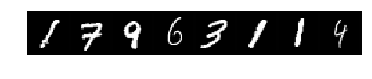

step 33, loss 17.269390106201172
Target:	 tensor([9, 0, 8, 1, 4, 6, 7, 2], device='cuda:0')
Pred:	 tensor([4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')


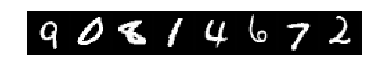

step 66, loss 20.722686767578125
Target:	 tensor([9, 3, 1, 0, 4, 4, 4, 4], device='cuda:0')
Pred:	 tensor([6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')


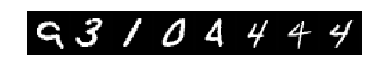

step 99, loss 14.678973197937012
Target:	 tensor([1, 6, 5, 2, 6, 6, 2, 7], device='cuda:0')
Pred:	 tensor([3, 6, 6, 0, 6, 6, 0, 3], device='cuda:0')


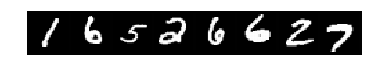

step 132, loss 10.005305290222168
Target:	 tensor([6, 8, 5, 8, 6, 0, 0, 3], device='cuda:0')
Pred:	 tensor([6, 4, 6, 2, 6, 0, 6, 3], device='cuda:0')


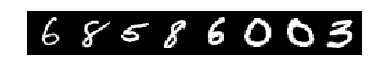

step 165, loss 13.06640911102295
Target:	 tensor([7, 4, 6, 0, 0, 1, 1, 5], device='cuda:0')
Pred:	 tensor([4, 4, 2, 0, 0, 2, 2, 2], device='cuda:0')


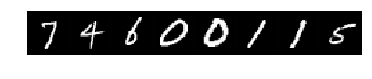

step 198, loss 9.484553337097168
Target:	 tensor([5, 3, 3, 9, 9, 9, 5, 6], device='cuda:0')
Pred:	 tensor([4, 3, 4, 2, 4, 4, 4, 6], device='cuda:0')


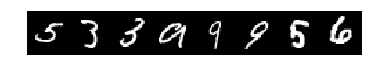

step 231, loss 12.914787292480469
Target:	 tensor([4, 5, 8, 7, 8, 1, 4, 7], device='cuda:0')
Pred:	 tensor([4, 4, 6, 3, 3, 1, 4, 4], device='cuda:0')


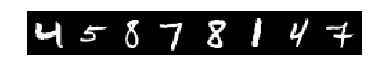

step 264, loss 7.584327220916748
Target:	 tensor([2, 8, 7, 8, 3, 4, 9, 7], device='cuda:0')
Pred:	 tensor([1, 5, 3, 1, 3, 1, 7, 7], device='cuda:0')


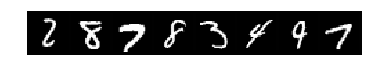

step 297, loss 6.807391166687012
Target:	 tensor([7, 7, 6, 1, 2, 1, 4, 4], device='cuda:0')
Pred:	 tensor([7, 7, 6, 1, 2, 1, 4, 4], device='cuda:0')


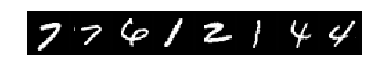

step 330, loss 6.049202919006348
Target:	 tensor([4, 2, 1, 3, 8, 2, 9, 0], device='cuda:0')
Pred:	 tensor([4, 2, 1, 3, 2, 2, 4, 0], device='cuda:0')


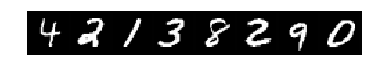

step 363, loss 1.3733537197113037
Target:	 tensor([5, 0, 4, 7, 4, 1, 6, 3], device='cuda:0')
Pred:	 tensor([5, 0, 4, 4, 4, 1, 6, 3], device='cuda:0')


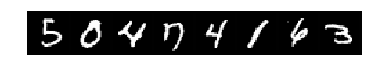

step 396, loss 3.6519713401794434
Target:	 tensor([7, 5, 2, 6, 5, 3, 2, 9], device='cuda:0')
Pred:	 tensor([7, 5, 2, 6, 5, 3, 2, 7], device='cuda:0')


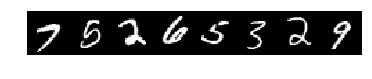

step 429, loss 0.5592606663703918
Target:	 tensor([4, 4, 5, 0, 6, 1, 6, 6], device='cuda:0')
Pred:	 tensor([4, 4, 5, 0, 6, 7, 6, 6], device='cuda:0')


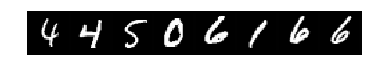

step 462, loss 1.0333976745605469
Target:	 tensor([2, 1, 7, 2, 8, 5, 8, 6], device='cuda:0')
Pred:	 tensor([2, 1, 7, 8, 8, 5, 8, 8], device='cuda:0')


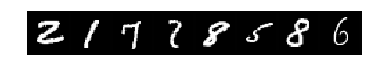

step 495, loss 0.21424254775047302
Target:	 tensor([1, 4, 3, 9, 7, 1, 1, 4], device='cuda:0')
Pred:	 tensor([1, 4, 3, 4, 7, 1, 1, 4], device='cuda:0')


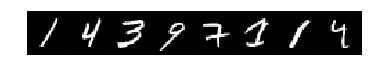

step 528, loss 0.08810263127088547
Target:	 tensor([8, 9, 8, 7, 6, 5, 3, 1], device='cuda:0')
Pred:	 tensor([8, 9, 8, 7, 6, 5, 3, 1], device='cuda:0')


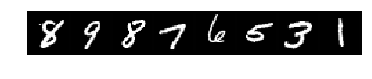

step 561, loss 0.06572853773832321
Target:	 tensor([5, 0, 5, 0, 6, 0, 0, 2], device='cuda:0')
Pred:	 tensor([5, 0, 5, 0, 6, 0, 0, 2], device='cuda:0')


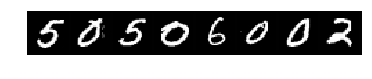

step 594, loss 0.00941784493625164
Target:	 tensor([1, 2, 6, 6, 0, 0, 3, 5], device='cuda:0')
Pred:	 tensor([1, 2, 6, 6, 0, 0, 3, 5], device='cuda:0')


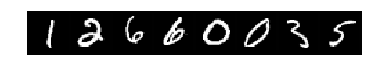

step 627, loss 0.02076229266822338
Target:	 tensor([9, 1, 5, 6, 1, 9, 7, 2], device='cuda:0')
Pred:	 tensor([9, 1, 5, 6, 1, 9, 7, 2], device='cuda:0')


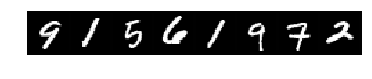

step 660, loss 0.008764399215579033
Target:	 tensor([9, 8, 5, 5, 5, 8, 4, 3], device='cuda:0')
Pred:	 tensor([9, 8, 5, 5, 5, 8, 4, 3], device='cuda:0')


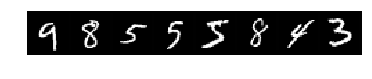

step 693, loss 0.5224204063415527
Target:	 tensor([3, 8, 3, 6, 6, 4, 2, 4], device='cuda:0')
Pred:	 tensor([3, 8, 3, 6, 6, 4, 2, 4], device='cuda:0')


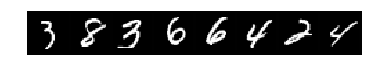

step 726, loss 0.006300322245806456
Target:	 tensor([1, 6, 9, 7, 7, 1, 7, 9], device='cuda:0')
Pred:	 tensor([1, 6, 9, 7, 7, 1, 7, 9], device='cuda:0')


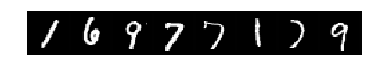

step 759, loss 0.045768819749355316
Target:	 tensor([9, 3, 5, 3, 5, 8, 2, 0], device='cuda:0')
Pred:	 tensor([9, 3, 5, 3, 5, 8, 2, 0], device='cuda:0')


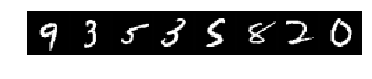

step 792, loss 0.01284484937787056
Target:	 tensor([1, 4, 6, 2, 9, 9, 8, 5], device='cuda:0')
Pred:	 tensor([1, 4, 6, 2, 9, 9, 8, 5], device='cuda:0')


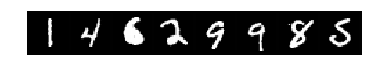

step 825, loss 0.027232781052589417
Target:	 tensor([6, 4, 9, 3, 7, 2, 2, 2], device='cuda:0')
Pred:	 tensor([6, 4, 9, 3, 7, 2, 2, 2], device='cuda:0')


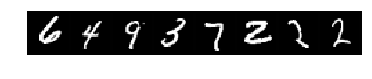

step 858, loss 0.02522405982017517
Target:	 tensor([2, 4, 3, 7, 7, 8, 0, 8], device='cuda:0')
Pred:	 tensor([2, 4, 3, 7, 7, 8, 0, 8], device='cuda:0')


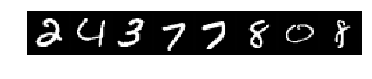

step 891, loss 0.016603466123342514
Target:	 tensor([1, 1, 4, 4, 0, 0, 5, 4], device='cuda:0')
Pred:	 tensor([1, 1, 4, 4, 0, 0, 5, 4], device='cuda:0')


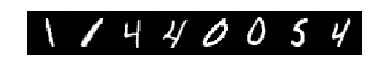

step 924, loss 0.013803314417600632
Target:	 tensor([9, 7, 4, 4, 4, 1, 3, 7], device='cuda:0')
Pred:	 tensor([9, 7, 4, 4, 4, 1, 3, 7], device='cuda:0')


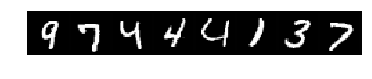

step 957, loss 0.005886902566999197
Target:	 tensor([7, 1, 0, 9, 0, 5, 2, 7], device='cuda:0')
Pred:	 tensor([7, 1, 0, 9, 0, 5, 2, 7], device='cuda:0')


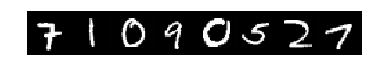

step 990, loss 0.009861582890152931
Target:	 tensor([0, 9, 4, 2, 3, 2, 8, 1], device='cuda:0')
Pred:	 tensor([0, 9, 4, 2, 3, 2, 8, 1], device='cuda:0')


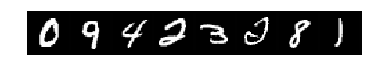

step 1023, loss 0.011333133094012737
Target:	 tensor([4, 3, 8, 7, 3, 9, 0, 8], device='cuda:0')
Pred:	 tensor([4, 3, 8, 7, 3, 9, 0, 8], device='cuda:0')


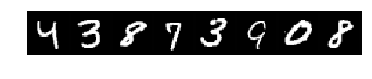

step 1056, loss 0.006470714695751667
Target:	 tensor([4, 1, 6, 3, 0, 6, 9, 0], device='cuda:0')
Pred:	 tensor([4, 1, 6, 3, 0, 6, 9, 0], device='cuda:0')


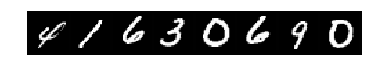

step 1089, loss 0.01293917279690504
Target:	 tensor([8, 3, 5, 4, 5, 1, 5, 7], device='cuda:0')
Pred:	 tensor([8, 3, 5, 4, 5, 1, 5, 7], device='cuda:0')


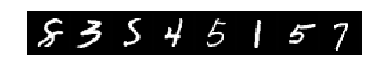

step 1122, loss 0.004658799152821302
Target:	 tensor([1, 1, 5, 7, 0, 3, 6, 2], device='cuda:0')
Pred:	 tensor([1, 1, 5, 7, 0, 3, 6, 2], device='cuda:0')


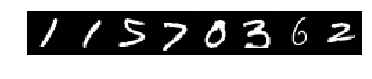

step 1155, loss 0.005574997514486313
Target:	 tensor([4, 4, 9, 5, 3, 0, 5, 1], device='cuda:0')
Pred:	 tensor([4, 4, 9, 5, 3, 0, 5, 1], device='cuda:0')


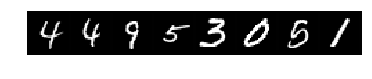

step 1188, loss 0.005826111882925034
Target:	 tensor([8, 9, 1, 6, 6, 4, 3, 3], device='cuda:0')
Pred:	 tensor([8, 9, 1, 6, 6, 4, 3, 3], device='cuda:0')


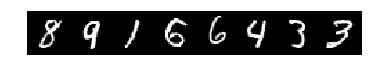

step 1221, loss 0.007030262611806393
Target:	 tensor([9, 5, 7, 2, 9, 7, 7, 7], device='cuda:0')
Pred:	 tensor([9, 5, 7, 2, 9, 7, 7, 7], device='cuda:0')


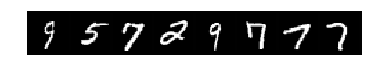

step 1254, loss 0.008547605946660042
Target:	 tensor([1, 7, 2, 6, 8, 1, 0, 5], device='cuda:0')
Pred:	 tensor([1, 7, 2, 6, 8, 1, 0, 5], device='cuda:0')


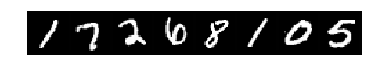

step 1287, loss 0.002496434608474374
Target:	 tensor([8, 6, 1, 1, 5, 8, 7, 6], device='cuda:0')
Pred:	 tensor([8, 6, 1, 1, 5, 8, 7, 6], device='cuda:0')


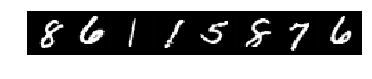

step 1320, loss 0.003319466020911932
Target:	 tensor([0, 0, 6, 4, 8, 9, 8, 1], device='cuda:0')
Pred:	 tensor([0, 0, 6, 4, 8, 9, 8, 1], device='cuda:0')


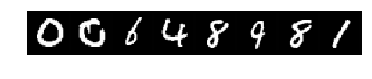

step 1353, loss 0.0028432593680918217
Target:	 tensor([9, 2, 0, 5, 8, 7, 1, 4], device='cuda:0')
Pred:	 tensor([9, 2, 0, 5, 8, 7, 1, 4], device='cuda:0')


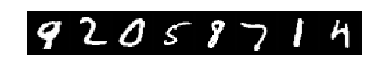

step 1386, loss 0.003326366189867258
Target:	 tensor([9, 9, 3, 2, 0, 5, 9, 0], device='cuda:0')
Pred:	 tensor([9, 9, 3, 2, 0, 5, 9, 0], device='cuda:0')


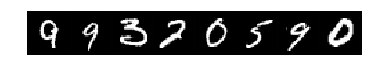

step 1419, loss 0.00521630747243762
Target:	 tensor([5, 8, 5, 7, 1, 1, 6, 5], device='cuda:0')
Pred:	 tensor([5, 8, 5, 7, 1, 1, 6, 5], device='cuda:0')


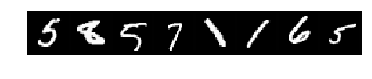

step 1452, loss 0.003354680724442005
Target:	 tensor([5, 3, 7, 9, 4, 8, 4, 6], device='cuda:0')
Pred:	 tensor([5, 3, 7, 9, 4, 8, 4, 6], device='cuda:0')


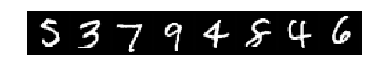

step 1485, loss 0.009109675884246826
Target:	 tensor([6, 8, 5, 2, 9, 3, 4, 5], device='cuda:0')
Pred:	 tensor([6, 8, 5, 2, 9, 3, 4, 5], device='cuda:0')


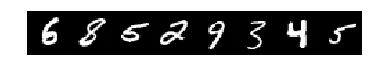

step 1518, loss 0.006141078658401966
Target:	 tensor([0, 7, 2, 6, 1, 9, 7, 7], device='cuda:0')
Pred:	 tensor([0, 7, 2, 6, 1, 9, 7, 7], device='cuda:0')


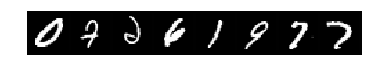

step 1551, loss 0.0018050407525151968
Target:	 tensor([6, 2, 7, 1, 1, 8, 3, 7], device='cuda:0')
Pred:	 tensor([6, 2, 7, 1, 1, 8, 3, 7], device='cuda:0')


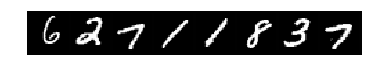

step 1584, loss 0.00226784311234951
Target:	 tensor([7, 7, 4, 2, 3, 8, 2, 8], device='cuda:0')
Pred:	 tensor([7, 7, 4, 2, 3, 8, 2, 8], device='cuda:0')


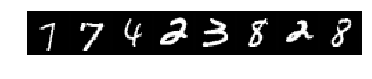

step 1617, loss 0.0015142107149586082
Target:	 tensor([3, 3, 1, 8, 5, 7, 7, 3], device='cuda:0')
Pred:	 tensor([3, 3, 1, 8, 5, 7, 7, 3], device='cuda:0')


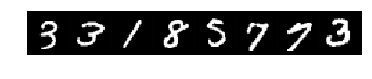

step 1650, loss 0.005291391164064407
Target:	 tensor([6, 1, 5, 4, 4, 7, 2, 9], device='cuda:0')
Pred:	 tensor([6, 1, 5, 4, 4, 7, 2, 9], device='cuda:0')


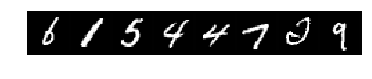

step 1683, loss 0.0010156281059607863
Target:	 tensor([1, 1, 3, 6, 6, 5, 2, 6], device='cuda:0')
Pred:	 tensor([1, 1, 3, 6, 6, 5, 2, 6], device='cuda:0')


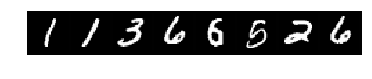

step 1716, loss 0.0018912971718236804
Target:	 tensor([0, 5, 0, 6, 3, 1, 9, 7], device='cuda:0')
Pred:	 tensor([0, 5, 0, 6, 3, 1, 9, 7], device='cuda:0')


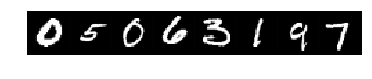

step 1749, loss 0.003080256748944521
Target:	 tensor([3, 9, 5, 9, 4, 1, 9, 2], device='cuda:0')
Pred:	 tensor([3, 9, 5, 9, 4, 1, 9, 2], device='cuda:0')


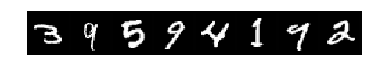

step 1782, loss 0.0018953669350594282
Target:	 tensor([1, 3, 4, 8, 7, 5, 6, 0], device='cuda:0')
Pred:	 tensor([1, 3, 4, 8, 7, 5, 6, 0], device='cuda:0')


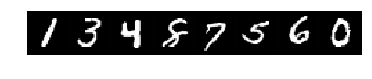

step 1815, loss 0.0012907194904983044
Target:	 tensor([3, 0, 3, 2, 8, 0, 0, 1], device='cuda:0')
Pred:	 tensor([3, 0, 3, 2, 8, 0, 0, 1], device='cuda:0')


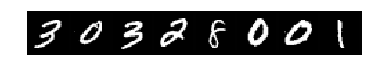

step 1848, loss 0.004156704992055893
Target:	 tensor([0, 2, 7, 0, 6, 2, 0, 4], device='cuda:0')
Pred:	 tensor([0, 2, 7, 0, 6, 2, 0, 4], device='cuda:0')


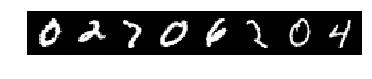

step 1881, loss 0.0035496680065989494
Target:	 tensor([2, 3, 4, 7, 4, 8, 6, 4], device='cuda:0')
Pred:	 tensor([2, 3, 4, 7, 4, 8, 6, 4], device='cuda:0')


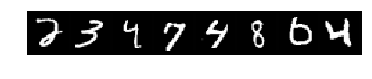

step 1914, loss 0.0014311763225123286
Target:	 tensor([5, 6, 1, 1, 8, 8, 5, 7], device='cuda:0')
Pred:	 tensor([5, 6, 1, 1, 8, 8, 5, 7], device='cuda:0')


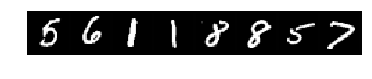

step 1947, loss 0.0030275534372776747
Target:	 tensor([7, 3, 6, 7, 8, 0, 3, 3], device='cuda:0')
Pred:	 tensor([7, 3, 6, 7, 8, 0, 3, 3], device='cuda:0')


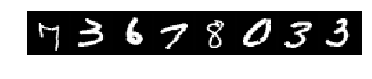

step 1980, loss 0.0022723025176674128
Target:	 tensor([9, 6, 7, 4, 6, 1, 5, 8], device='cuda:0')
Pred:	 tensor([9, 6, 7, 4, 6, 1, 5, 8], device='cuda:0')


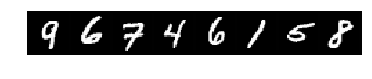

step 2013, loss 0.004244609735906124
Target:	 tensor([4, 9, 5, 1, 8, 8, 5, 8], device='cuda:0')
Pred:	 tensor([4, 9, 5, 1, 8, 8, 5, 8], device='cuda:0')


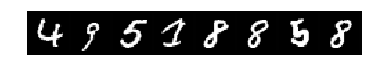

step 2046, loss 0.0032289219088852406
Target:	 tensor([3, 5, 9, 8, 8, 7, 3, 7], device='cuda:0')
Pred:	 tensor([3, 5, 9, 8, 8, 7, 3, 7], device='cuda:0')


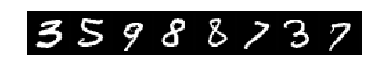

step 2079, loss 0.0012416639365255833
Target:	 tensor([6, 1, 4, 7, 0, 3, 2, 6], device='cuda:0')
Pred:	 tensor([6, 1, 4, 7, 0, 3, 2, 6], device='cuda:0')


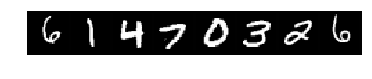

step 2112, loss 0.0020870317239314318
Target:	 tensor([5, 6, 3, 2, 6, 4, 9, 8], device='cuda:0')
Pred:	 tensor([5, 6, 3, 2, 6, 4, 9, 8], device='cuda:0')


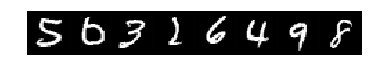

step 2145, loss 0.002490028738975525
Target:	 tensor([2, 9, 8, 2, 3, 3, 5, 5], device='cuda:0')
Pred:	 tensor([2, 9, 8, 2, 3, 3, 5, 5], device='cuda:0')


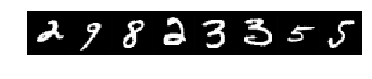

step 2178, loss 0.0013264240697026253
Target:	 tensor([9, 5, 2, 4, 6, 1, 8, 4], device='cuda:0')
Pred:	 tensor([9, 5, 2, 4, 6, 1, 8, 4], device='cuda:0')


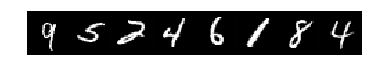

step 2211, loss 0.0009308563312515616
Target:	 tensor([6, 1, 4, 7, 4, 3, 3, 2], device='cuda:0')
Pred:	 tensor([6, 1, 4, 7, 4, 3, 3, 2], device='cuda:0')


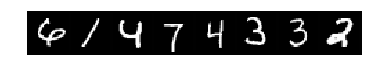

step 2244, loss 0.0012827360769733787
Target:	 tensor([9, 4, 1, 9, 0, 0, 9, 2], device='cuda:0')
Pred:	 tensor([9, 4, 1, 9, 0, 0, 9, 2], device='cuda:0')


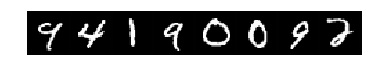

step 2277, loss 0.001407506293617189
Target:	 tensor([7, 3, 7, 3, 3, 5, 1, 1], device='cuda:0')
Pred:	 tensor([7, 3, 7, 3, 3, 5, 1, 1], device='cuda:0')


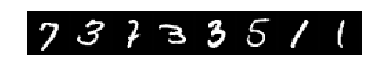

step 2310, loss 0.002045449335128069
Target:	 tensor([4, 7, 7, 1, 3, 9, 0, 6], device='cuda:0')
Pred:	 tensor([4, 7, 7, 1, 3, 9, 0, 6], device='cuda:0')


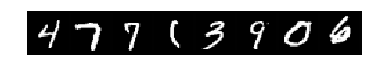

step 2343, loss 0.002122690202668309
Target:	 tensor([6, 8, 7, 6, 6, 2, 4, 8], device='cuda:0')
Pred:	 tensor([6, 8, 7, 6, 6, 2, 4, 8], device='cuda:0')


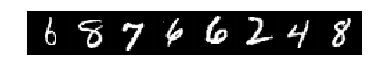

step 2376, loss 0.0005678567686118186
Target:	 tensor([5, 4, 8, 1, 6, 3, 4, 6], device='cuda:0')
Pred:	 tensor([5, 4, 8, 1, 6, 3, 4, 6], device='cuda:0')


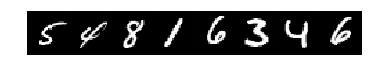

step 2409, loss 0.0014561372809112072
Target:	 tensor([9, 9, 6, 6, 8, 4, 8, 1], device='cuda:0')
Pred:	 tensor([9, 9, 6, 6, 8, 4, 8, 1], device='cuda:0')


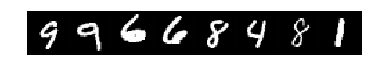

step 2442, loss 0.0024195618461817503
Target:	 tensor([3, 3, 2, 7, 7, 2, 4, 7], device='cuda:0')
Pred:	 tensor([3, 3, 2, 7, 7, 2, 4, 7], device='cuda:0')


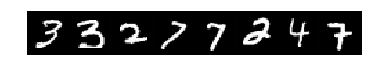

step 2475, loss 0.0008656043792143464
Target:	 tensor([1, 8, 1, 4, 5, 5, 6, 3], device='cuda:0')
Pred:	 tensor([1, 8, 1, 4, 5, 5, 6, 3], device='cuda:0')


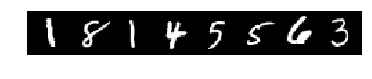

step 2508, loss 0.00240669259801507
Target:	 tensor([8, 8, 1, 2, 6, 9, 2, 6], device='cuda:0')
Pred:	 tensor([8, 8, 1, 2, 6, 9, 2, 6], device='cuda:0')


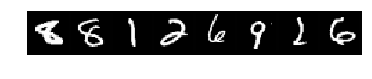

step 2541, loss 0.002071989234536886
Target:	 tensor([8, 1, 2, 7, 4, 7, 0, 2], device='cuda:0')
Pred:	 tensor([8, 1, 2, 7, 4, 7, 0, 2], device='cuda:0')


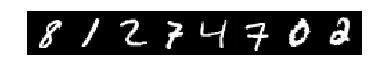

step 2574, loss 0.0026595816016197205
Target:	 tensor([6, 8, 1, 0, 9, 6, 3, 0], device='cuda:0')
Pred:	 tensor([6, 8, 1, 0, 9, 6, 3, 0], device='cuda:0')


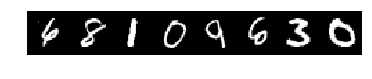

step 2607, loss 0.001836067414842546
Target:	 tensor([4, 1, 3, 8, 7, 3, 5, 2], device='cuda:0')
Pred:	 tensor([4, 1, 3, 8, 7, 3, 5, 2], device='cuda:0')


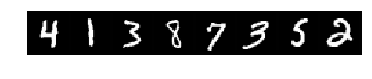

step 2640, loss 0.0023896931670606136
Target:	 tensor([6, 3, 5, 0, 8, 9, 0, 9], device='cuda:0')
Pred:	 tensor([6, 3, 5, 0, 8, 9, 0, 9], device='cuda:0')


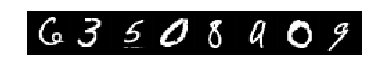

step 2673, loss 0.0008393566822633147
Target:	 tensor([4, 2, 7, 8, 1, 5, 5, 7], device='cuda:0')
Pred:	 tensor([4, 2, 7, 8, 1, 5, 5, 7], device='cuda:0')


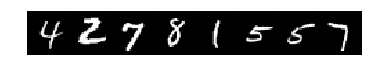

step 2706, loss 0.0008002709364518523
Target:	 tensor([9, 9, 6, 4, 4, 9, 5, 5], device='cuda:0')
Pred:	 tensor([9, 9, 6, 4, 4, 9, 5, 5], device='cuda:0')


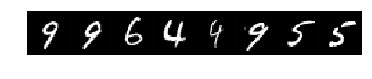

step 2739, loss 0.0009052536333911121
Target:	 tensor([0, 3, 5, 9, 7, 0, 7, 1], device='cuda:0')
Pred:	 tensor([0, 3, 5, 9, 7, 0, 7, 1], device='cuda:0')


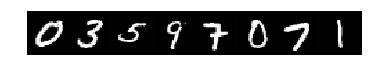

step 2772, loss 0.00284338416531682
Target:	 tensor([0, 2, 4, 1, 7, 2, 8, 3], device='cuda:0')
Pred:	 tensor([0, 2, 4, 1, 7, 2, 8, 3], device='cuda:0')


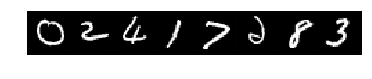

step 2805, loss 0.001619724789634347
Target:	 tensor([1, 1, 9, 4, 6, 7, 3, 2], device='cuda:0')
Pred:	 tensor([1, 1, 9, 4, 6, 7, 3, 2], device='cuda:0')


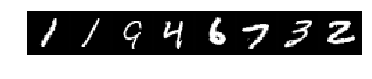

step 2838, loss 0.002499950584024191
Target:	 tensor([1, 5, 6, 9, 5, 8, 5, 3], device='cuda:0')
Pred:	 tensor([1, 5, 6, 9, 5, 8, 5, 3], device='cuda:0')


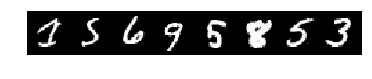

step 2871, loss 0.0008655176497995853
Target:	 tensor([7, 3, 1, 9, 7, 8, 0, 4], device='cuda:0')
Pred:	 tensor([7, 3, 1, 9, 7, 8, 0, 4], device='cuda:0')


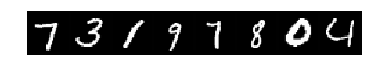

step 2904, loss 0.001871989807114005
Target:	 tensor([7, 5, 5, 3, 4, 1, 0, 0], device='cuda:0')
Pred:	 tensor([7, 5, 5, 3, 4, 1, 0, 0], device='cuda:0')


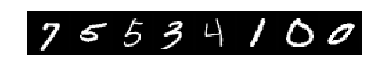

step 2937, loss 0.0018203234067186713
Target:	 tensor([5, 9, 1, 6, 6, 3, 7, 4], device='cuda:0')
Pred:	 tensor([5, 9, 1, 6, 6, 3, 7, 4], device='cuda:0')


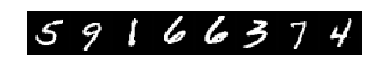

step 2970, loss 0.002758538816124201
Target:	 tensor([0, 8, 4, 2, 9, 1, 0, 3], device='cuda:0')
Pred:	 tensor([0, 8, 4, 2, 9, 1, 0, 3], device='cuda:0')


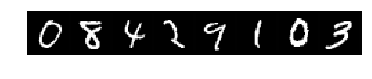

step 3003, loss 0.0012137601152062416
Target:	 tensor([4, 9, 7, 7, 3, 8, 5, 9], device='cuda:0')
Pred:	 tensor([4, 9, 7, 7, 3, 8, 5, 9], device='cuda:0')


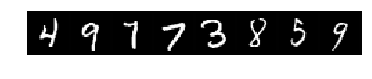

step 3036, loss 0.00028281507547944784
Target:	 tensor([2, 1, 2, 4, 4, 4, 5, 2], device='cuda:0')
Pred:	 tensor([2, 1, 2, 4, 4, 4, 5, 2], device='cuda:0')


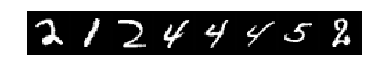

step 3069, loss 0.0020678387954831123
Target:	 tensor([7, 4, 7, 0, 1, 1, 0, 8], device='cuda:0')
Pred:	 tensor([7, 4, 7, 0, 1, 1, 0, 8], device='cuda:0')


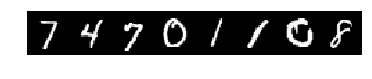

step 3102, loss 0.0013928182888776064
Target:	 tensor([1, 8, 8, 6, 7, 9, 7, 9], device='cuda:0')
Pred:	 tensor([1, 8, 8, 6, 7, 9, 7, 9], device='cuda:0')


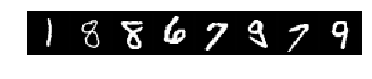

step 3135, loss 0.0006481488817371428
Target:	 tensor([8, 5, 0, 7, 3, 5, 6, 4], device='cuda:0')
Pred:	 tensor([8, 5, 0, 7, 3, 5, 6, 4], device='cuda:0')


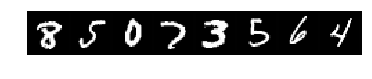

step 3168, loss 0.001968739088624716
Target:	 tensor([2, 4, 7, 0, 2, 2, 4, 9], device='cuda:0')
Pred:	 tensor([2, 4, 7, 0, 2, 2, 4, 9], device='cuda:0')


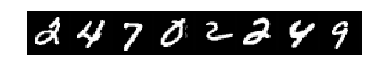

step 3201, loss 0.0011353774461895227
Target:	 tensor([8, 3, 9, 3, 4, 7, 3, 2], device='cuda:0')
Pred:	 tensor([8, 3, 9, 3, 4, 7, 3, 2], device='cuda:0')


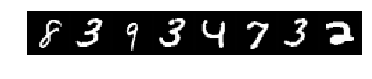

step 3234, loss 0.0007010146509855986
Target:	 tensor([4, 3, 5, 4, 0, 3, 7, 5], device='cuda:0')
Pred:	 tensor([4, 3, 5, 4, 0, 3, 7, 5], device='cuda:0')


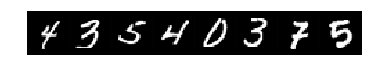

step 3267, loss 0.00040904409252107143
Target:	 tensor([3, 5, 1, 2, 8, 1, 8, 8], device='cuda:0')
Pred:	 tensor([3, 5, 1, 2, 8, 1, 8, 8], device='cuda:0')


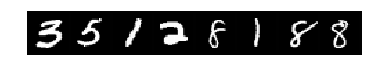

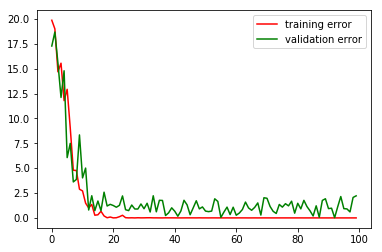

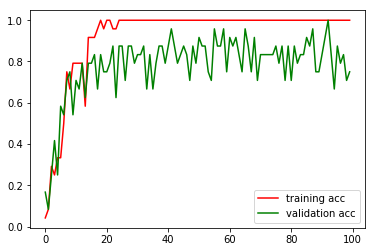

In [13]:
# learning rate, hyper-parameter
lr = 1e-3

# using GPU if it's availble
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

net = LeNet(img_channel, device)
# keep a list of moel parameters
params = [p for (n, p) in net.named_parameters()]

# training epochs, hyper-parameter
epochs = 100

# keep tracking of the changing of loss and accuracy of predictions
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# the printing frequency, feel free to change this
print_interval = 50
for e in range(epochs):
  net.train()
  for i, (imgs, lbs) in enumerate(train_dl):
    imgs = imgs.to(device)
    lbs = lbs.to(device)
    loss, prob = net(imgs, lbs)
    
    net.zero_grad()
    grad = torch.autograd.grad(loss, params)
    
    # update weights
    step(params, grad, lr)
    
    # obtain the predictions
    pred = prob.argmax(dim=-1).view(batch_size)
    acc = (pred == lbs).float().mean()
    
    if i % print_interval == 0:
      print("step {}, loss {}".format(i + e*len(train_dl), loss))
      print("Target:\t {}\nPred:\t {}".format(lbs[:8], pred[:8]))
      # visualize some samples
      imgs_to_vis = vutils.make_grid(imgs[:8].cpu()+125., nrow=8, pad_value=1)
      plt.imshow(imgs_to_vis.permute(1,2,0).numpy().astype(np.uint8))
      plt.axis("off")
      plt.show()
      
  train_loss_list.append(loss.detach().mean())
  train_acc_list.append(acc.detach().mean())
  
  net.eval()
  for i, (imgs, lbs) in enumerate(val_dl):
    imgs = imgs.to(device)
    lbs = lbs.to(device)
    loss, prob = net(imgs, lbs)
    
    pred = prob.argmax(dim=-1).view(batch_size)
    acc = (pred == lbs).float().mean()
    
  val_loss_list.append(loss.detach().mean())
  val_acc_list.append(acc.detach().mean())
  

# ploting logs
plt.plot(np.arange(epochs), train_loss_list, '-r',
         np.arange(epochs), val_loss_list, '-g')
plt.legend(('training error', 'validation error'))
plt.show()
plt.plot(np.arange(epochs), train_acc_list, '-r',
         np.arange(epochs), val_acc_list, '-g')
plt.legend(('training acc', 'validation acc'))
plt.show()

## Guide: Model Saving and Loading

Once the training is completed, we can save the model on disk for evaluation or future use. It is also helpful to save the model regularly in case of unexcepted situations. Below is the snippet of how to save and load a model. More information can be found [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html). You will be asked to evaluate your LeNet in the end.
```python
# Saving a model on disk:
torch.save(net.state_dict(), PATH_to_save)

# Loading a model from disk:
net = LeNet(img_c)
net.load_state_dict(torch.load(PATH_to_save))
```

## Task 5: Weight Decay

As we can see, LeNet now is overfitted on this 1k dataset. Instead of providing more data, we can use Weight Decay to improve its generalization ability.

**To-dos**: 
    - (5 points)Write the dataset loading script, training script
    - (5 points)Add **weights penalty** into the loss function.
    - (10 points)Train LeNet from scratch.
    - (10 points)Plot out the training loss curve, validation loss curve, training accuracy curve, and validation accuracy curve as those plots in the above section.

In [23]:
def weight_decay(loss, weights, lamb, batch):
    # add the weight decay penalty to the loss  
    penalty = torch.tensor(0.0).cuda()
    num_w = torch.tensor(0.0).cuda()
    i=0
    for w in weights:
        if i%2==0:
            penalty += (w*w).sum()
            num_w += w.clone().reshape(1,-1).shape[1]
    l = torch.tensor(0.5*lamb).cuda()
    loss += l*penalty/torch.tensor(batch).float().cuda()
    return loss

e 0, step 0, loss 44.088890075683594
Target:	 tensor([8, 6, 7, 6, 6, 9, 9, 1], device='cuda:0')
Pred:	 tensor([7, 7, 2, 7, 7, 2, 7, 7], device='cuda:0')


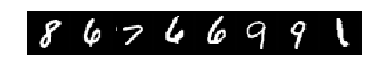

e 60, step 2000, loss 18.280153274536133
Target:	 tensor([9, 6, 1, 8, 7, 1, 1, 5], device='cuda:0')
Pred:	 tensor([9, 6, 1, 8, 7, 1, 1, 5], device='cuda:0')


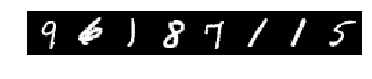

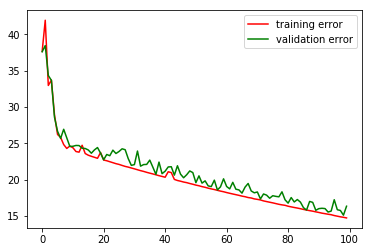

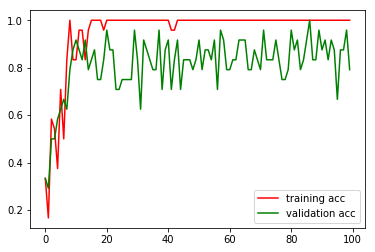

In [18]:
################################################################################################################################
# Dataset loading script
dataset_size = 1000
validation_size = int(0.2 * 1000)

ds = MNISTDataset(ds_size=dataset_size)

# split the dataset into training set and validation set
train_ds, val_ds = torch.utils.data.random_split(ds, [dataset_size - validation_size, validation_size])

# training batch size, hyper-parameter
batch_size = 24

# dataset loader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, drop_last=True)
img_channel = 1

################################################################################################################################
# Training script
# learning rate, hyper-parameter
lr = 1e-3

# using GPU if it's availble
device = torch.device('cuda')

net = LeNet(img_channel, device)
# keep a list of moel parameters
params = [p for (n, p) in net.named_parameters()]

# training epochs, hyper-parameter
epochs = 100

# keep tracking of the changing of loss and accuracy of predictions
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
print_interval = 350
for e in range(epochs):
  net.train()
  for i, (imgs, lbs) in enumerate(train_dl):
    imgs = imgs.to(device)
    lbs = lbs.to(device)
    loss, prob = net(imgs, lbs)
    # add the weight decay penalty to the loss  
    lamb = 2.0   
    loss = weight_decay(loss, params, lamb, lbs.shape[0])
    
    net.zero_grad()
    grad = torch.autograd.grad(loss, params)
    
    # update weights
    step(params, grad, lr)
    
    # obtain the predictions
    pred = prob.argmax(dim=-1).view(batch_size)
    acc = (pred == lbs).float().mean()
    
    if (i + e*len(train_dl))% print_interval == 0:
      print("e {}, step {}, loss {}".format( e, i + e*len(train_dl), loss))
      print("Target:\t {}\nPred:\t {}".format(lbs[:8], pred[:8]))
      # visualize some samples
      imgs_to_vis = vutils.make_grid(imgs[:8].cpu()+125., nrow=8, pad_value=1)
      plt.imshow(imgs_to_vis.permute(1,2,0).numpy().astype(np.uint8))
      plt.axis("off")
      plt.show()  
    
  train_loss_list.append(loss.detach().mean())
  train_acc_list.append(acc.detach().mean())
  
  net.eval()
  for i, (imgs, lbs) in enumerate(val_dl):
    imgs = imgs.to(device)
    lbs = lbs.to(device)
    loss, prob = net(imgs, lbs)
    loss = weight_decay(loss, params, lamb, lbs.shape[0])
    
    pred = prob.argmax(dim=-1).view(batch_size)
    acc = (pred == lbs).float().mean()
    
  val_loss_list.append(loss.detach().mean())
  val_acc_list.append(acc.detach().mean())
  

# ploting logs
plt.plot(np.arange(epochs), train_loss_list, '-r',
         np.arange(epochs), val_loss_list, '-g')
plt.legend(('training error', 'validation error'))
plt.show()
plt.plot(np.arange(epochs), train_acc_list, '-r',
         np.arange(epochs), val_acc_list, '-g')
plt.legend(('training acc', 'validation acc'))
plt.show()

## Task 6: Dropout

[Dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) can also help with generalization. It randomly drops units from the neural network during training. Thus, training a neural network with dropout can be seen as training a collection of many sub-networks.

**To-dos**:
    - (5 points)Complete the **dropout_forward()** function for class Dropout.
    - (5 points)Modify the class LeNet with dropout layer and build a new class named LeNetDrop: add a dropout layer after layer c1, layer c3, and layer c5.
    - Write the dataset loading script, training script.
    - Train LeNetDrop on the 1k dataset.
    - (10 points)Plot out the training loss curve, validation loss curve, training accuracy curve and validation accuracy curve.

In [17]:
class Dropout(nn.Module):
  def __init__(self, p, device):
    super(Dropout, self).__init__()
    """
    inputs:
     p: scalar, the probability of an element to be zeroed.
    """
    self.p = p
    self.device = device
    
    
  def dropout_forward(self, X, training=True):
    """
    inputs:
      X: (N, *), input of dropout layer
      training: boolean, apply dropout if true. Note: We do not apply dropout during testing.
    outputs:
      Y: (N, *)
    """
    ### Start the code here  ###
    if training == True:
        dr = (torch.rand(X.shape) > self.p).cuda().float()
        Y = X*dr
        Y = Y/(1.0-self.p)
    else:
        Y = X
    
    ###  End of the code ###
    return Y
  
  def forward(self, X, training=True):
    return self.dropout_forward(X, training)

In [18]:
# dataset loading, training script and other codes starts here:
# LeNetDrop sketch code
class LeNetDrop(nn.Module):
  def __init__(self, img_c, device):
    super(LeNetDrop, self).__init__()
    drop_p = 0.2
    self.c1 = Conv2D(img_c, 6, [5,5], [1,1], [2,2,2,2], device)
    self.d1 = Dropout(drop_p, device)
    self.p2 = nn.MaxPool2d(2, stride=2)
    self.c3 = Conv2D(6, 16, [5,5], [1,1], [0,0,0,0], device)
    self.d3 = Dropout(drop_p, device)
    self.p4 = nn.MaxPool2d(2, stride=2)
    self.f5 = Linear(400, 120, device)
    self.d5 = Dropout(drop_p, device)
    self.f6 = Linear(120, 84, device)
    self.f7 = Linear(84, 10, device)
    self.device = device
    
  def forward(self, imgs, labels, training=True):
    """
    inputs:
      imgs: (N, C, H, W), training samples from the MNIST training set, where N is the number of samples (batch_size),
          C is the image color channle number, H and W are the spatial size of the input images.
      labels: (N, L), ground truth for the input images, where N is the number of samples (batch_size) and L is the 
          number of classes.
    outputs:
      loss: (1,), mean loss value over this batch of inputs.
    
    """
    N = imgs.shape[0]
    
    o_c1 = F.relu(self.c1(imgs))
    o_d1 = self.d1(o_c1, training)
    o_p2 = self.p2(o_d1)
    o_c3 = F.relu(self.c3(o_p2))
    o_d3 = self.d3(o_c3, training)
    o_p4 = self.p4(o_d3)
    
    ### Start the code here  ###
    # 1. Please complete the rest of LeNet to get the scores predicted by LeNet for each input images #
    # need to flatten the matrix before forwarding to the dense layer    
    o_f5 = F.relu(self.f5(o_p4.reshape(o_p4.shape[0], -1)))
    o_d5 = self.d5(o_f5, training)
    o_f6 = F.relu(self.f6(o_d5))
    o_f7 = self.f7(o_f6)
    # 2. Please use the implemented objective function to obtain the losses of each input. #
    p = softmax1d(o_f7)  
    # 3. We will return the mean value of the losses. #
    loss = cross_entropy_loss(p, labels)
    ###  End of the code ###
    return loss.mean(), p

e 0, step 0, loss 40.31529235839844
Target:	 tensor([6, 3, 4, 0, 9, 9, 4, 9], device='cuda:0')
Pred:	 tensor([6, 0, 7, 0, 6, 9, 0, 6], device='cuda:0')


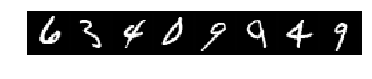

e 10, step 350, loss 31.059011459350586
Target:	 tensor([5, 6, 4, 3, 3, 7, 5, 9], device='cuda:0')
Pred:	 tensor([5, 6, 4, 3, 3, 7, 5, 7], device='cuda:0')


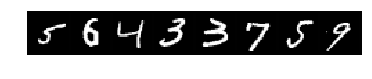

e 21, step 700, loss 23.398168563842773
Target:	 tensor([5, 0, 7, 1, 4, 3, 5, 2], device='cuda:0')
Pred:	 tensor([5, 0, 7, 1, 4, 3, 5, 2], device='cuda:0')


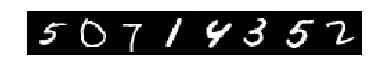

e 31, step 1050, loss 22.58089256286621
Target:	 tensor([2, 1, 7, 2, 9, 3, 1, 5], device='cuda:0')
Pred:	 tensor([2, 1, 7, 0, 9, 0, 5, 5], device='cuda:0')


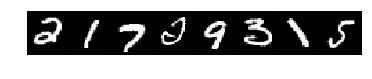

e 42, step 1400, loss 20.371061325073242
Target:	 tensor([3, 0, 8, 8, 4, 8, 5, 9], device='cuda:0')
Pred:	 tensor([3, 0, 8, 8, 4, 6, 5, 9], device='cuda:0')


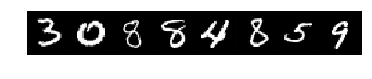

e 53, step 1750, loss 19.366426467895508
Target:	 tensor([9, 4, 7, 6, 4, 6, 3, 5], device='cuda:0')
Pred:	 tensor([7, 4, 7, 6, 4, 6, 3, 5], device='cuda:0')


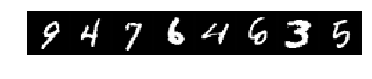

e 63, step 2100, loss 18.303951263427734
Target:	 tensor([7, 2, 7, 4, 2, 1, 9, 0], device='cuda:0')
Pred:	 tensor([7, 2, 7, 4, 2, 1, 9, 0], device='cuda:0')


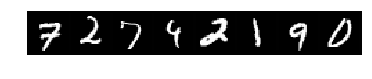

e 74, step 2450, loss 16.978912353515625
Target:	 tensor([7, 7, 0, 7, 8, 9, 1, 4], device='cuda:0')
Pred:	 tensor([7, 7, 0, 7, 8, 9, 1, 4], device='cuda:0')


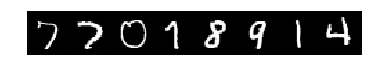

e 84, step 2800, loss 16.1416072845459
Target:	 tensor([8, 8, 4, 2, 8, 5, 6, 2], device='cuda:0')
Pred:	 tensor([8, 5, 4, 2, 8, 5, 6, 2], device='cuda:0')


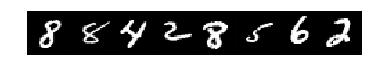

e 95, step 3150, loss 15.568328857421875
Target:	 tensor([5, 1, 6, 0, 2, 9, 7, 2], device='cuda:0')
Pred:	 tensor([5, 1, 6, 0, 2, 9, 7, 2], device='cuda:0')


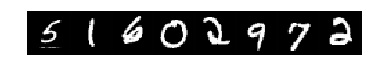

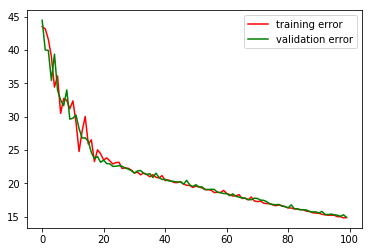

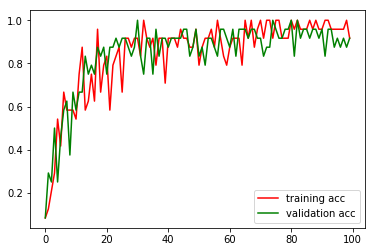

In [21]:
################################################################################################################################
# Train LeNetDrop on the 1k dataset
################################################################################################################################
# Dataset loading script
dataset_size = 1000
validation_size = int(0.2 * 1000)

ds = MNISTDataset(ds_size=dataset_size)

# split the dataset into training set and validation set
train_ds, val_ds = torch.utils.data.random_split(ds, [dataset_size - validation_size, validation_size])

# training batch size, hyper-parameter
batch_size = 24

# dataset loader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, drop_last=True)
img_channel = 1

################################################################################################################################
# Training script
# learning rate, hyper-parameter
lr = 1e-3

# using GPU if it's availble
device = torch.device('cuda')

net = LeNetDrop(img_channel, device)
# keep a list of moel parameters
params = [p for (n, p) in net.named_parameters()]

# training epochs, hyper-parameter
epochs = 100

# keep tracking of the changing of loss and accuracy of predictions
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
print_interval = 350
for e in range(epochs):
  net.train()
  for i, (imgs, lbs) in enumerate(train_dl):
    imgs = imgs.to(device)
    lbs = lbs.to(device)
    loss, prob = net(imgs, lbs, training=True)
     # add the weight decay penalty to the loss  
    lamb = 2.0   
    loss = weight_decay(loss, params, lamb, lbs.shape[0])
    
    net.zero_grad()
    grad = torch.autograd.grad(loss, params)
    
    # update weights
    step(params, grad, lr)
    
    # obtain the predictions
    pred = prob.argmax(dim=-1).view(batch_size)
    acc = (pred == lbs).float().mean()
    if (i + e*len(train_dl)) % print_interval == 0:
      print("e {}, step {}, loss {}".format( e, i + e*len(train_dl), loss))
      print("Target:\t {}\nPred:\t {}".format(lbs[:8], pred[:8]))
      # visualize some samples
      imgs_to_vis = vutils.make_grid(imgs[:8].cpu()+125., nrow=8, pad_value=1)
      plt.imshow(imgs_to_vis.permute(1,2,0).numpy().astype(np.uint8))
      plt.axis("off")
      plt.show()   
  train_loss_list.append(loss.detach().mean())
  train_acc_list.append(acc.detach().mean())
  
  net.eval()
  for i, (imgs, lbs) in enumerate(val_dl):
    imgs = imgs.to(device)
    lbs = lbs.to(device)
    loss, prob = net(imgs, lbs, False)
    # add the weight decay penalty to the loss  
    lamb = 2.0   
    loss = weight_decay(loss, params, lamb, lbs.shape[0])   
    
    pred = prob.argmax(dim=-1).view(batch_size)
    acc = (pred == lbs).float().mean()
    
  val_loss_list.append(loss.detach().mean())
  val_acc_list.append(acc.detach().mean())
  

# ploting logs
plt.plot(np.arange(epochs), train_loss_list, '-r',
         np.arange(epochs), val_loss_list, '-g')
plt.legend(('training error', 'validation error'))
plt.show()
plt.plot(np.arange(epochs), train_acc_list, '-r',
         np.arange(epochs), val_acc_list, '-g')
plt.legend(('training acc', 'validation acc'))
plt.show()

## Task 7: Train on full dataset

Now, train the LeNetDrop on the full MNIST dataset. 

**To-do**:
    - Write the dataset loading script, training script for LeNetDrop.
    - Train LeNetDrop on the full MNIST dataset below.
    - (10 points)Plot out the training loss curve, validation loss curve, training accuracy curve and validation accuracy curve.

In [19]:
################################################################################################################################
# Train LeNetDrop on the full dataset
################################################################################################################################
# Dataset loading script
train_ds = MNISTDataset(60000, split = "training")
val_ds = MNISTDataset(10000, split = "validation")

# training batch size, hyper-parameter
batch_size = 24

# dataset loader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, drop_last=True)
img_channel = 1

e 0, step 0, loss 45.258338928222656
Target:	 tensor([3, 1, 4, 7, 1, 9, 5, 4], device='cuda:0')
Pred:	 tensor([0, 8, 0, 4, 0, 4, 8, 0], device='cuda:0')


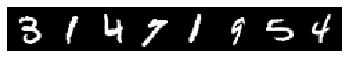

e 0, step 2000, loss 18.759445190429688
Target:	 tensor([5, 7, 7, 6, 4, 3, 1, 5], device='cuda:0')
Pred:	 tensor([5, 7, 7, 6, 4, 0, 1, 5], device='cuda:0')


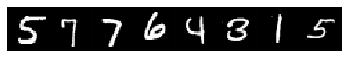

e 1, step 4000, loss 13.546051025390625
Target:	 tensor([2, 2, 6, 1, 4, 0, 3, 6], device='cuda:0')
Pred:	 tensor([2, 2, 6, 1, 6, 0, 3, 6], device='cuda:0')


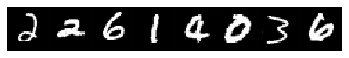

e 2, step 6000, loss 9.396353721618652
Target:	 tensor([3, 3, 1, 8, 7, 4, 6, 8], device='cuda:0')
Pred:	 tensor([3, 3, 1, 8, 7, 4, 6, 8], device='cuda:0')


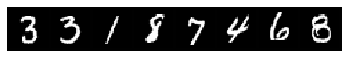

e 3, step 8000, loss 6.7225799560546875
Target:	 tensor([7, 7, 0, 4, 5, 7, 6, 7], device='cuda:0')
Pred:	 tensor([7, 7, 0, 4, 5, 7, 6, 7], device='cuda:0')


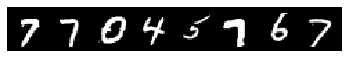

e 4, step 10000, loss 4.936184883117676
Target:	 tensor([4, 8, 3, 7, 3, 2, 5, 2], device='cuda:0')
Pred:	 tensor([4, 8, 3, 7, 3, 2, 5, 2], device='cuda:0')


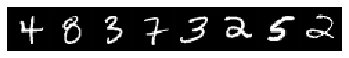

e 4, step 12000, loss 3.538346767425537
Target:	 tensor([1, 5, 5, 3, 5, 7, 4, 9], device='cuda:0')
Pred:	 tensor([1, 5, 5, 3, 5, 7, 4, 9], device='cuda:0')


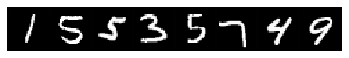

e 5, step 14000, loss 2.6060330867767334
Target:	 tensor([1, 7, 8, 1, 1, 4, 1, 7], device='cuda:0')
Pred:	 tensor([1, 7, 8, 1, 1, 4, 1, 7], device='cuda:0')


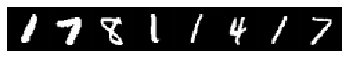

e 6, step 16000, loss 2.0112721920013428
Target:	 tensor([1, 5, 2, 2, 4, 2, 2, 0], device='cuda:0')
Pred:	 tensor([1, 5, 2, 2, 4, 2, 2, 0], device='cuda:0')


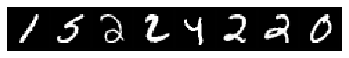

e 7, step 18000, loss 1.5799720287322998
Target:	 tensor([7, 6, 8, 0, 8, 8, 2, 2], device='cuda:0')
Pred:	 tensor([7, 6, 8, 0, 8, 8, 2, 2], device='cuda:0')


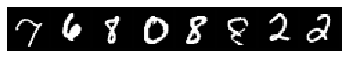

e 8, step 20000, loss 1.06905996799469
Target:	 tensor([0, 4, 1, 3, 2, 1, 8, 1], device='cuda:0')
Pred:	 tensor([0, 4, 1, 3, 2, 1, 8, 1], device='cuda:0')


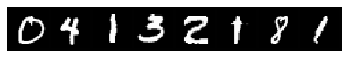

e 8, step 22000, loss 0.8557407855987549
Target:	 tensor([3, 4, 1, 6, 1, 4, 2, 0], device='cuda:0')
Pred:	 tensor([3, 4, 1, 6, 1, 4, 2, 0], device='cuda:0')


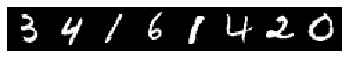

e 9, step 24000, loss 0.6700837016105652
Target:	 tensor([1, 1, 8, 0, 0, 1, 6, 0], device='cuda:0')
Pred:	 tensor([1, 1, 8, 0, 0, 1, 6, 0], device='cuda:0')


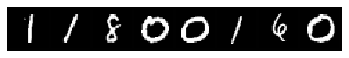

e 10, step 26000, loss 0.6538465023040771
Target:	 tensor([3, 0, 4, 8, 6, 5, 7, 2], device='cuda:0')
Pred:	 tensor([3, 2, 4, 8, 6, 5, 7, 2], device='cuda:0')


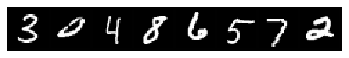

e 11, step 28000, loss 0.49029141664505005
Target:	 tensor([1, 6, 4, 0, 9, 6, 1, 3], device='cuda:0')
Pred:	 tensor([1, 6, 4, 0, 9, 6, 1, 3], device='cuda:0')


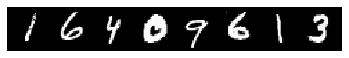

e 12, step 30000, loss 0.4289899170398712
Target:	 tensor([5, 9, 3, 4, 8, 1, 8, 7], device='cuda:0')
Pred:	 tensor([5, 9, 3, 4, 8, 1, 8, 9], device='cuda:0')


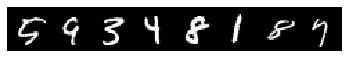

e 12, step 32000, loss 0.5417484045028687
Target:	 tensor([0, 2, 5, 5, 4, 0, 1, 6], device='cuda:0')
Pred:	 tensor([0, 2, 5, 5, 4, 0, 1, 6], device='cuda:0')


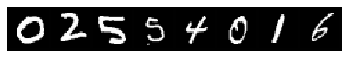

e 13, step 34000, loss 0.39304643869400024
Target:	 tensor([7, 5, 4, 9, 8, 0, 7, 1], device='cuda:0')
Pred:	 tensor([7, 5, 4, 9, 8, 0, 7, 1], device='cuda:0')


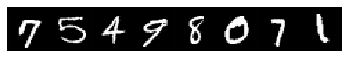

e 14, step 36000, loss 0.2979143559932709
Target:	 tensor([3, 0, 2, 4, 1, 4, 3, 7], device='cuda:0')
Pred:	 tensor([3, 0, 2, 4, 1, 4, 3, 7], device='cuda:0')


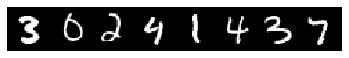

e 15, step 38000, loss 0.42486128211021423
Target:	 tensor([2, 1, 7, 0, 1, 2, 8, 8], device='cuda:0')
Pred:	 tensor([3, 1, 7, 0, 1, 2, 8, 8], device='cuda:0')


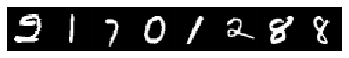

e 16, step 40000, loss 0.2586093544960022
Target:	 tensor([7, 7, 5, 0, 1, 3, 1, 7], device='cuda:0')
Pred:	 tensor([7, 7, 5, 0, 1, 3, 1, 7], device='cuda:0')


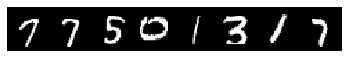

e 16, step 42000, loss 0.5022361874580383
Target:	 tensor([6, 9, 9, 4, 8, 9, 0, 7], device='cuda:0')
Pred:	 tensor([6, 3, 9, 4, 8, 9, 0, 7], device='cuda:0')


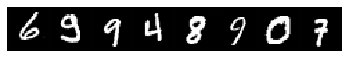

e 17, step 44000, loss 0.2821335196495056
Target:	 tensor([7, 8, 2, 7, 8, 8, 7, 5], device='cuda:0')
Pred:	 tensor([7, 8, 2, 7, 8, 8, 7, 5], device='cuda:0')


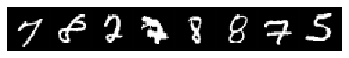

e 18, step 46000, loss 0.2434415966272354
Target:	 tensor([9, 2, 1, 1, 3, 4, 1, 7], device='cuda:0')
Pred:	 tensor([9, 2, 1, 1, 3, 4, 1, 7], device='cuda:0')


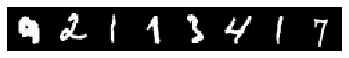

e 19, step 48000, loss 0.2974969744682312
Target:	 tensor([8, 2, 5, 4, 8, 3, 0, 7], device='cuda:0')
Pred:	 tensor([8, 2, 5, 4, 8, 3, 0, 7], device='cuda:0')


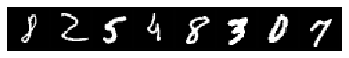

e 20, step 50000, loss 0.251396507024765
Target:	 tensor([7, 2, 9, 6, 2, 1, 6, 7], device='cuda:0')
Pred:	 tensor([7, 2, 9, 6, 2, 1, 6, 7], device='cuda:0')


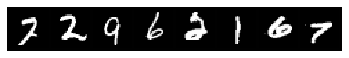

e 20, step 52000, loss 0.2520684003829956
Target:	 tensor([1, 8, 1, 7, 6, 3, 1, 1], device='cuda:0')
Pred:	 tensor([1, 8, 1, 7, 6, 3, 1, 1], device='cuda:0')


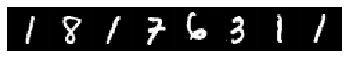

e 21, step 54000, loss 0.24324554204940796
Target:	 tensor([6, 5, 1, 9, 9, 9, 6, 7], device='cuda:0')
Pred:	 tensor([6, 5, 1, 9, 9, 9, 6, 7], device='cuda:0')


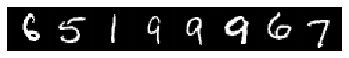

e 22, step 56000, loss 0.2629275619983673
Target:	 tensor([9, 2, 8, 8, 9, 4, 8, 0], device='cuda:0')
Pred:	 tensor([9, 2, 8, 8, 9, 4, 8, 0], device='cuda:0')


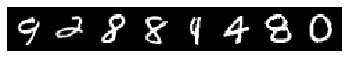

e 23, step 58000, loss 0.2249755859375
Target:	 tensor([9, 6, 0, 8, 4, 7, 9, 7], device='cuda:0')
Pred:	 tensor([9, 6, 0, 8, 4, 7, 9, 7], device='cuda:0')


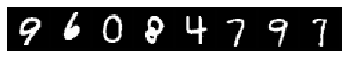

e 24, step 60000, loss 0.28642648458480835
Target:	 tensor([7, 1, 3, 8, 3, 7, 2, 2], device='cuda:0')
Pred:	 tensor([7, 1, 3, 8, 3, 7, 2, 2], device='cuda:0')


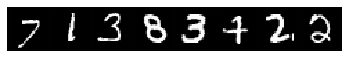

e 24, step 62000, loss 0.21237778663635254
Target:	 tensor([6, 8, 7, 3, 9, 7, 8, 3], device='cuda:0')
Pred:	 tensor([6, 8, 7, 3, 9, 7, 8, 3], device='cuda:0')


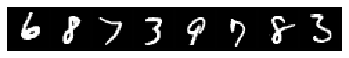

e 25, step 64000, loss 0.3239150941371918
Target:	 tensor([3, 5, 0, 4, 1, 7, 4, 8], device='cuda:0')
Pred:	 tensor([3, 5, 0, 4, 1, 7, 4, 8], device='cuda:0')


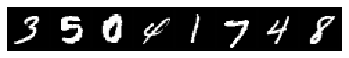

e 26, step 66000, loss 0.20264635980129242
Target:	 tensor([7, 4, 6, 6, 2, 2, 9, 0], device='cuda:0')
Pred:	 tensor([7, 4, 6, 6, 2, 2, 9, 0], device='cuda:0')


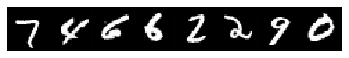

e 27, step 68000, loss 0.25085484981536865
Target:	 tensor([9, 3, 1, 0, 2, 6, 7, 4], device='cuda:0')
Pred:	 tensor([9, 3, 1, 0, 2, 6, 7, 4], device='cuda:0')


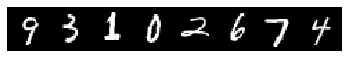

e 28, step 70000, loss 0.34856224060058594
Target:	 tensor([3, 9, 8, 5, 7, 1, 6, 9], device='cuda:0')
Pred:	 tensor([3, 9, 8, 5, 7, 1, 6, 9], device='cuda:0')


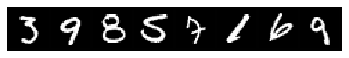

e 28, step 72000, loss 0.27126139402389526
Target:	 tensor([6, 0, 5, 3, 4, 0, 2, 0], device='cuda:0')
Pred:	 tensor([6, 0, 5, 3, 4, 0, 2, 0], device='cuda:0')


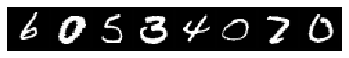

e 29, step 74000, loss 0.3506920337677002
Target:	 tensor([9, 7, 7, 7, 2, 5, 4, 0], device='cuda:0')
Pred:	 tensor([9, 7, 7, 7, 2, 5, 4, 0], device='cuda:0')


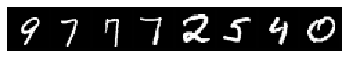

e 30, step 76000, loss 0.20774713158607483
Target:	 tensor([7, 4, 4, 6, 0, 2, 0, 5], device='cuda:0')
Pred:	 tensor([7, 4, 4, 6, 0, 2, 0, 5], device='cuda:0')


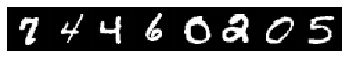

e 31, step 78000, loss 0.22745007276535034
Target:	 tensor([7, 3, 9, 6, 6, 5, 6, 2], device='cuda:0')
Pred:	 tensor([7, 3, 9, 6, 6, 5, 6, 2], device='cuda:0')


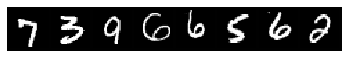

e 32, step 80000, loss 0.23046478629112244
Target:	 tensor([7, 4, 6, 2, 3, 3, 8, 8], device='cuda:0')
Pred:	 tensor([7, 4, 6, 2, 3, 3, 8, 8], device='cuda:0')


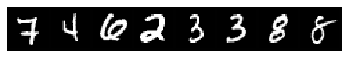

e 32, step 82000, loss 0.20866142213344574
Target:	 tensor([7, 0, 8, 1, 8, 2, 8, 3], device='cuda:0')
Pred:	 tensor([7, 0, 8, 1, 8, 2, 8, 3], device='cuda:0')


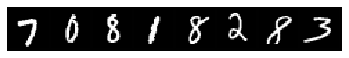

e 33, step 84000, loss 0.26251378655433655
Target:	 tensor([3, 4, 8, 2, 3, 6, 2, 6], device='cuda:0')
Pred:	 tensor([3, 4, 8, 2, 3, 6, 2, 6], device='cuda:0')


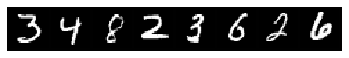

e 34, step 86000, loss 0.26466721296310425
Target:	 tensor([6, 1, 7, 4, 2, 8, 7, 2], device='cuda:0')
Pred:	 tensor([6, 1, 7, 4, 2, 8, 7, 2], device='cuda:0')


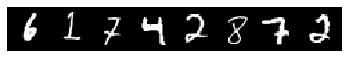

e 35, step 88000, loss 0.2130233347415924
Target:	 tensor([8, 2, 0, 6, 8, 4, 0, 6], device='cuda:0')
Pred:	 tensor([8, 2, 0, 6, 8, 4, 0, 6], device='cuda:0')


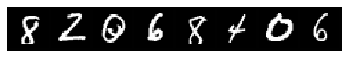

e 36, step 90000, loss 0.26777076721191406
Target:	 tensor([7, 0, 2, 4, 9, 1, 0, 7], device='cuda:0')
Pred:	 tensor([7, 2, 2, 4, 9, 1, 0, 7], device='cuda:0')


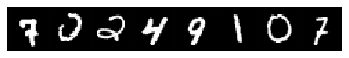

e 36, step 92000, loss 0.2653909921646118
Target:	 tensor([4, 7, 2, 1, 0, 4, 5, 8], device='cuda:0')
Pred:	 tensor([4, 7, 2, 1, 0, 4, 5, 8], device='cuda:0')


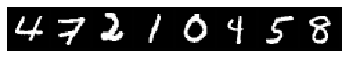

e 37, step 94000, loss 0.20144307613372803
Target:	 tensor([4, 5, 0, 7, 4, 3, 7, 0], device='cuda:0')
Pred:	 tensor([4, 5, 0, 7, 4, 3, 7, 0], device='cuda:0')


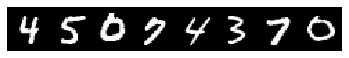

e 38, step 96000, loss 0.3582932949066162
Target:	 tensor([3, 3, 1, 8, 8, 4, 6, 2], device='cuda:0')
Pred:	 tensor([3, 3, 1, 8, 8, 4, 6, 2], device='cuda:0')


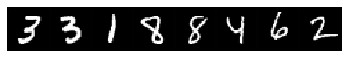

e 39, step 98000, loss 0.20364491641521454
Target:	 tensor([0, 1, 3, 4, 6, 1, 7, 4], device='cuda:0')
Pred:	 tensor([0, 1, 3, 4, 6, 1, 7, 4], device='cuda:0')


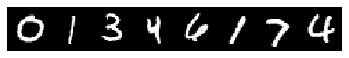

e 40, step 100000, loss 0.21123895049095154
Target:	 tensor([7, 5, 6, 8, 6, 9, 0, 3], device='cuda:0')
Pred:	 tensor([7, 5, 6, 8, 6, 9, 0, 3], device='cuda:0')


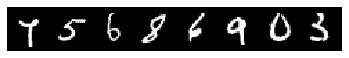

e 40, step 102000, loss 0.30827152729034424
Target:	 tensor([2, 1, 2, 7, 6, 4, 0, 2], device='cuda:0')
Pred:	 tensor([2, 1, 2, 7, 6, 4, 0, 2], device='cuda:0')


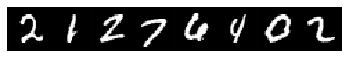

e 41, step 104000, loss 0.40713948011398315
Target:	 tensor([3, 0, 3, 4, 2, 5, 4, 3], device='cuda:0')
Pred:	 tensor([3, 0, 3, 4, 2, 5, 4, 3], device='cuda:0')


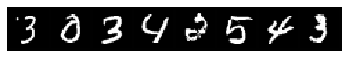

e 42, step 106000, loss 0.22978179156780243
Target:	 tensor([4, 2, 8, 6, 3, 9, 7, 1], device='cuda:0')
Pred:	 tensor([4, 2, 8, 6, 3, 9, 7, 1], device='cuda:0')


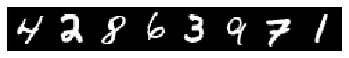

e 43, step 108000, loss 0.43083497881889343
Target:	 tensor([8, 3, 2, 0, 3, 7, 5, 7], device='cuda:0')
Pred:	 tensor([8, 3, 2, 0, 3, 7, 5, 2], device='cuda:0')


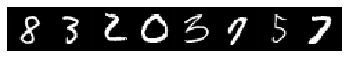

e 44, step 110000, loss 0.24697725474834442
Target:	 tensor([7, 5, 5, 5, 8, 4, 9, 2], device='cuda:0')
Pred:	 tensor([7, 5, 5, 5, 8, 4, 9, 2], device='cuda:0')


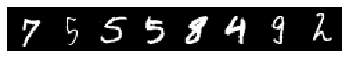

e 44, step 112000, loss 0.24559302628040314
Target:	 tensor([6, 5, 3, 3, 1, 9, 9, 1], device='cuda:0')
Pred:	 tensor([6, 5, 3, 3, 1, 4, 9, 1], device='cuda:0')


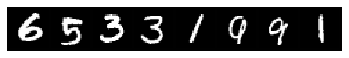

e 45, step 114000, loss 0.22144173085689545
Target:	 tensor([7, 8, 5, 8, 0, 6, 4, 9], device='cuda:0')
Pred:	 tensor([7, 8, 5, 8, 0, 6, 4, 9], device='cuda:0')


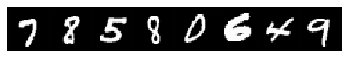

e 46, step 116000, loss 0.1986529380083084
Target:	 tensor([5, 7, 9, 5, 3, 2, 8, 3], device='cuda:0')
Pred:	 tensor([5, 7, 9, 5, 3, 2, 8, 3], device='cuda:0')


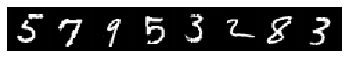

e 47, step 118000, loss 0.2182689905166626
Target:	 tensor([8, 5, 7, 8, 9, 7, 2, 5], device='cuda:0')
Pred:	 tensor([8, 5, 7, 8, 9, 7, 2, 5], device='cuda:0')


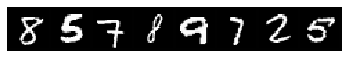

e 48, step 120000, loss 0.24669942259788513
Target:	 tensor([6, 6, 3, 8, 2, 5, 7, 8], device='cuda:0')
Pred:	 tensor([6, 6, 3, 8, 2, 5, 7, 8], device='cuda:0')


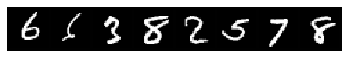

e 48, step 122000, loss 0.21693159639835358
Target:	 tensor([1, 4, 7, 5, 8, 7, 5, 8], device='cuda:0')
Pred:	 tensor([1, 4, 7, 5, 8, 7, 5, 8], device='cuda:0')


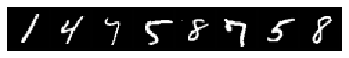

e 49, step 124000, loss 0.21607306599617004
Target:	 tensor([6, 1, 0, 5, 3, 9, 6, 9], device='cuda:0')
Pred:	 tensor([6, 1, 0, 5, 3, 9, 6, 9], device='cuda:0')


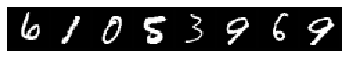

e 50, step 126000, loss 0.30115222930908203
Target:	 tensor([0, 3, 9, 6, 5, 9, 1, 7], device='cuda:0')
Pred:	 tensor([0, 3, 9, 6, 5, 9, 1, 7], device='cuda:0')


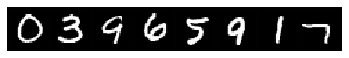

e 51, step 128000, loss 0.34286022186279297
Target:	 tensor([0, 9, 8, 3, 6, 3, 1, 4], device='cuda:0')
Pred:	 tensor([0, 9, 8, 3, 6, 2, 1, 4], device='cuda:0')


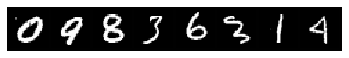

e 52, step 130000, loss 0.3344825506210327
Target:	 tensor([7, 8, 1, 4, 4, 2, 6, 4], device='cuda:0')
Pred:	 tensor([4, 8, 1, 9, 4, 2, 6, 4], device='cuda:0')


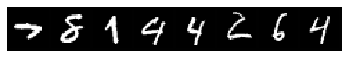

e 52, step 132000, loss 0.22589246928691864
Target:	 tensor([6, 2, 7, 5, 6, 8, 1, 1], device='cuda:0')
Pred:	 tensor([6, 2, 7, 5, 6, 8, 1, 1], device='cuda:0')


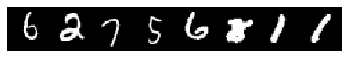

e 53, step 134000, loss 0.20860764384269714
Target:	 tensor([6, 5, 0, 9, 9, 8, 5, 0], device='cuda:0')
Pred:	 tensor([6, 5, 0, 9, 9, 8, 5, 0], device='cuda:0')


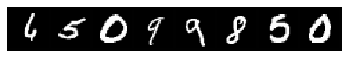

e 54, step 136000, loss 0.1999923586845398
Target:	 tensor([2, 2, 9, 4, 2, 4, 2, 9], device='cuda:0')
Pred:	 tensor([2, 2, 9, 4, 2, 4, 2, 9], device='cuda:0')


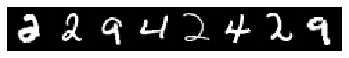

e 55, step 138000, loss 0.19996346533298492
Target:	 tensor([3, 1, 7, 6, 2, 0, 2, 1], device='cuda:0')
Pred:	 tensor([3, 1, 7, 6, 2, 0, 2, 1], device='cuda:0')


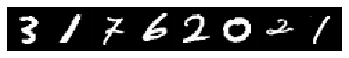

e 56, step 140000, loss 0.19718068838119507
Target:	 tensor([1, 8, 1, 1, 5, 7, 6, 3], device='cuda:0')
Pred:	 tensor([1, 8, 1, 1, 5, 7, 6, 3], device='cuda:0')


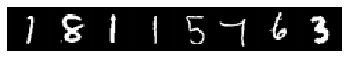

e 56, step 142000, loss 0.2202605903148651
Target:	 tensor([3, 4, 0, 9, 7, 5, 0, 0], device='cuda:0')
Pred:	 tensor([3, 4, 0, 9, 7, 5, 0, 0], device='cuda:0')


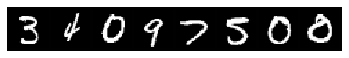

e 57, step 144000, loss 0.23822985589504242
Target:	 tensor([6, 2, 9, 0, 9, 7, 6, 5], device='cuda:0')
Pred:	 tensor([6, 2, 9, 0, 9, 7, 0, 5], device='cuda:0')


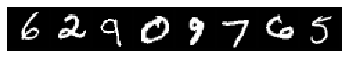

e 58, step 146000, loss 0.18683098256587982
Target:	 tensor([9, 4, 4, 3, 6, 4, 9, 7], device='cuda:0')
Pred:	 tensor([9, 4, 4, 3, 6, 4, 9, 7], device='cuda:0')


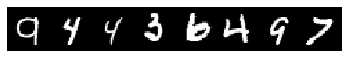

e 59, step 148000, loss 0.4197006821632385
Target:	 tensor([3, 2, 2, 3, 3, 5, 8, 4], device='cuda:0')
Pred:	 tensor([3, 2, 3, 3, 3, 5, 8, 4], device='cuda:0')


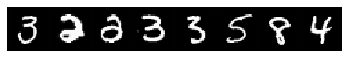

e 60, step 150000, loss 0.2731650471687317
Target:	 tensor([0, 6, 2, 7, 7, 5, 6, 1], device='cuda:0')
Pred:	 tensor([0, 6, 2, 7, 7, 5, 6, 8], device='cuda:0')


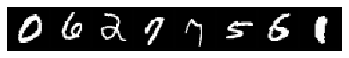

e 60, step 152000, loss 0.2503570020198822
Target:	 tensor([7, 3, 2, 1, 1, 8, 7, 1], device='cuda:0')
Pred:	 tensor([7, 3, 2, 1, 1, 8, 7, 1], device='cuda:0')


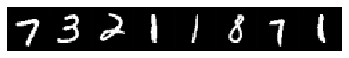

e 61, step 154000, loss 0.20371848344802856
Target:	 tensor([3, 4, 7, 0, 8, 7, 0, 3], device='cuda:0')
Pred:	 tensor([3, 4, 7, 0, 8, 7, 0, 3], device='cuda:0')


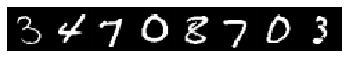

e 62, step 156000, loss 0.21197852492332458
Target:	 tensor([7, 0, 8, 5, 1, 9, 9, 5], device='cuda:0')
Pred:	 tensor([7, 0, 8, 5, 1, 9, 9, 5], device='cuda:0')


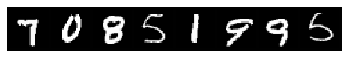

e 63, step 158000, loss 0.24664781987667084
Target:	 tensor([3, 0, 2, 4, 9, 7, 7, 1], device='cuda:0')
Pred:	 tensor([3, 0, 2, 4, 9, 7, 7, 1], device='cuda:0')


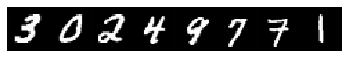

e 64, step 160000, loss 0.23666898906230927
Target:	 tensor([9, 5, 0, 2, 8, 1, 7, 2], device='cuda:0')
Pred:	 tensor([9, 5, 0, 2, 8, 1, 7, 2], device='cuda:0')


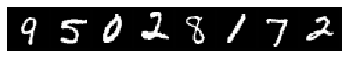

e 64, step 162000, loss 0.21137672662734985
Target:	 tensor([6, 4, 6, 8, 7, 6, 5, 7], device='cuda:0')
Pred:	 tensor([6, 4, 6, 8, 7, 6, 5, 7], device='cuda:0')


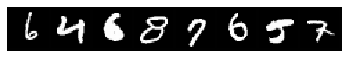

e 65, step 164000, loss 0.25137513875961304
Target:	 tensor([4, 1, 9, 5, 9, 6, 8, 0], device='cuda:0')
Pred:	 tensor([4, 1, 9, 5, 9, 6, 8, 0], device='cuda:0')


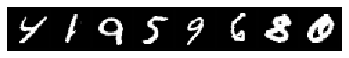

e 66, step 166000, loss 0.21092897653579712
Target:	 tensor([5, 5, 8, 3, 4, 1, 5, 6], device='cuda:0')
Pred:	 tensor([5, 5, 8, 3, 4, 1, 5, 6], device='cuda:0')


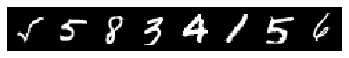

e 67, step 168000, loss 0.41123777627944946
Target:	 tensor([9, 4, 5, 0, 3, 8, 8, 2], device='cuda:0')
Pred:	 tensor([9, 4, 5, 0, 9, 8, 8, 2], device='cuda:0')


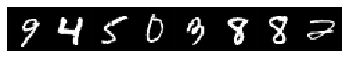

e 68, step 170000, loss 0.2300581932067871
Target:	 tensor([6, 9, 1, 3, 3, 0, 3, 9], device='cuda:0')
Pred:	 tensor([6, 9, 1, 3, 3, 0, 3, 9], device='cuda:0')


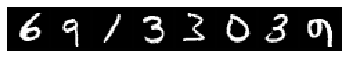

e 68, step 172000, loss 0.4018319547176361
Target:	 tensor([1, 1, 9, 0, 0, 7, 4, 0], device='cuda:0')
Pred:	 tensor([1, 1, 9, 0, 0, 7, 4, 6], device='cuda:0')


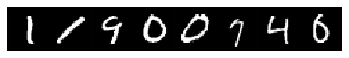

e 69, step 174000, loss 0.3300042152404785
Target:	 tensor([4, 0, 5, 6, 8, 6, 2, 5], device='cuda:0')
Pred:	 tensor([4, 0, 5, 6, 8, 6, 2, 5], device='cuda:0')


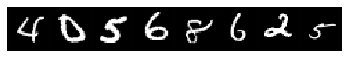

e 70, step 176000, loss 0.31812232732772827
Target:	 tensor([4, 9, 2, 8, 7, 0, 1, 1], device='cuda:0')
Pred:	 tensor([4, 9, 2, 8, 7, 0, 1, 1], device='cuda:0')


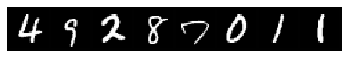

e 71, step 178000, loss 0.23327434062957764
Target:	 tensor([9, 1, 0, 5, 3, 8, 3, 4], device='cuda:0')
Pred:	 tensor([9, 1, 0, 5, 3, 8, 3, 4], device='cuda:0')


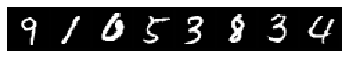

e 72, step 180000, loss 0.25247544050216675
Target:	 tensor([8, 4, 2, 1, 1, 1, 5, 4], device='cuda:0')
Pred:	 tensor([8, 4, 2, 1, 1, 1, 5, 4], device='cuda:0')


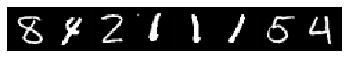

e 72, step 182000, loss 0.39648184180259705
Target:	 tensor([5, 5, 6, 1, 3, 2, 1, 4], device='cuda:0')
Pred:	 tensor([5, 5, 6, 1, 3, 2, 1, 4], device='cuda:0')


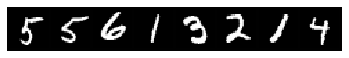

e 73, step 184000, loss 0.4915977120399475
Target:	 tensor([7, 9, 4, 0, 8, 6, 7, 7], device='cuda:0')
Pred:	 tensor([4, 9, 4, 0, 8, 6, 7, 7], device='cuda:0')


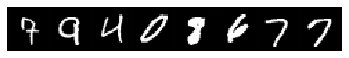

e 74, step 186000, loss 0.19474978744983673
Target:	 tensor([6, 8, 2, 6, 7, 8, 7, 4], device='cuda:0')
Pred:	 tensor([6, 8, 2, 6, 7, 8, 7, 4], device='cuda:0')


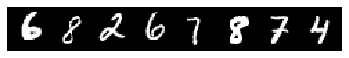

e 75, step 188000, loss 0.5243025422096252
Target:	 tensor([1, 8, 4, 9, 3, 3, 8, 3], device='cuda:0')
Pred:	 tensor([1, 8, 4, 9, 3, 3, 8, 3], device='cuda:0')


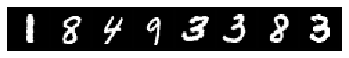

e 76, step 190000, loss 0.20132921636104584
Target:	 tensor([9, 8, 5, 2, 2, 6, 5, 4], device='cuda:0')
Pred:	 tensor([9, 8, 5, 2, 2, 6, 5, 4], device='cuda:0')


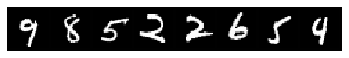

e 76, step 192000, loss 0.24694707989692688
Target:	 tensor([2, 9, 7, 0, 4, 0, 0, 2], device='cuda:0')
Pred:	 tensor([2, 9, 7, 0, 4, 0, 0, 2], device='cuda:0')


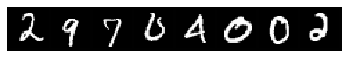

e 77, step 194000, loss 0.1933869570493698
Target:	 tensor([7, 8, 0, 3, 2, 1, 7, 6], device='cuda:0')
Pred:	 tensor([7, 8, 0, 3, 2, 1, 7, 6], device='cuda:0')


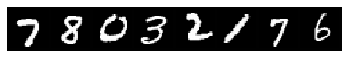

e 78, step 196000, loss 0.2940853238105774
Target:	 tensor([2, 3, 7, 2, 6, 8, 3, 6], device='cuda:0')
Pred:	 tensor([8, 3, 7, 2, 6, 8, 3, 6], device='cuda:0')


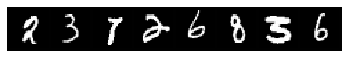

e 79, step 198000, loss 0.237261563539505
Target:	 tensor([8, 9, 6, 7, 3, 4, 2, 5], device='cuda:0')
Pred:	 tensor([8, 9, 6, 7, 3, 4, 2, 5], device='cuda:0')


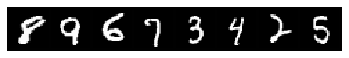

e 80, step 200000, loss 0.19705039262771606
Target:	 tensor([4, 3, 2, 2, 6, 1, 3, 6], device='cuda:0')
Pred:	 tensor([4, 3, 2, 2, 6, 1, 3, 6], device='cuda:0')


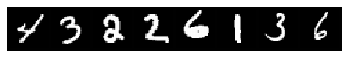

e 80, step 202000, loss 0.444485068321228
Target:	 tensor([9, 1, 7, 3, 2, 6, 4, 8], device='cuda:0')
Pred:	 tensor([9, 1, 7, 3, 2, 6, 4, 8], device='cuda:0')


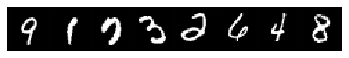

e 81, step 204000, loss 0.402957022190094
Target:	 tensor([0, 7, 5, 1, 1, 5, 0, 8], device='cuda:0')
Pred:	 tensor([0, 7, 9, 1, 1, 5, 0, 8], device='cuda:0')


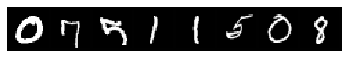

e 82, step 206000, loss 0.26242944598197937
Target:	 tensor([3, 5, 7, 0, 6, 1, 9, 6], device='cuda:0')
Pred:	 tensor([3, 5, 7, 0, 6, 1, 9, 6], device='cuda:0')


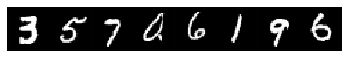

e 83, step 208000, loss 0.25037142634391785
Target:	 tensor([5, 6, 3, 8, 2, 3, 1, 1], device='cuda:0')
Pred:	 tensor([5, 6, 3, 8, 2, 3, 1, 1], device='cuda:0')


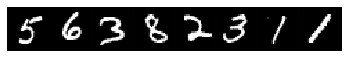

e 84, step 210000, loss 0.2539176344871521
Target:	 tensor([1, 6, 0, 5, 8, 7, 1, 9], device='cuda:0')
Pred:	 tensor([1, 6, 0, 5, 8, 7, 1, 9], device='cuda:0')


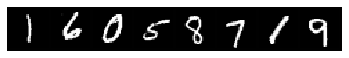

e 84, step 212000, loss 0.3109821677207947
Target:	 tensor([3, 3, 2, 1, 3, 0, 6, 7], device='cuda:0')
Pred:	 tensor([3, 3, 2, 1, 3, 0, 6, 7], device='cuda:0')


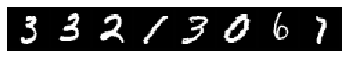

e 85, step 214000, loss 0.3416498005390167
Target:	 tensor([0, 8, 8, 1, 4, 9, 9, 1], device='cuda:0')
Pred:	 tensor([0, 8, 8, 1, 4, 9, 9, 1], device='cuda:0')


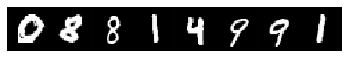

e 86, step 216000, loss 0.2438945472240448
Target:	 tensor([8, 2, 2, 2, 8, 4, 1, 4], device='cuda:0')
Pred:	 tensor([8, 2, 2, 2, 8, 4, 1, 4], device='cuda:0')


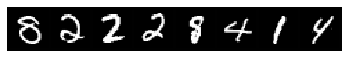

e 87, step 218000, loss 0.3577214479446411
Target:	 tensor([3, 4, 3, 9, 8, 9, 0, 0], device='cuda:0')
Pred:	 tensor([3, 1, 3, 9, 8, 9, 0, 0], device='cuda:0')


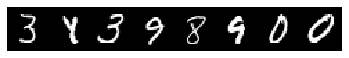

e 88, step 220000, loss 0.2549368441104889
Target:	 tensor([7, 4, 9, 6, 4, 5, 8, 7], device='cuda:0')
Pred:	 tensor([7, 4, 9, 6, 4, 5, 8, 7], device='cuda:0')


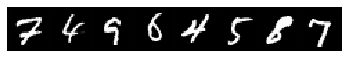

e 88, step 222000, loss 0.20837688446044922
Target:	 tensor([4, 2, 9, 1, 1, 4, 1, 5], device='cuda:0')
Pred:	 tensor([4, 2, 9, 1, 1, 4, 1, 5], device='cuda:0')


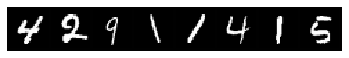

e 89, step 224000, loss 0.2294844686985016
Target:	 tensor([7, 0, 1, 1, 1, 8, 1, 3], device='cuda:0')
Pred:	 tensor([7, 0, 1, 1, 1, 8, 1, 3], device='cuda:0')


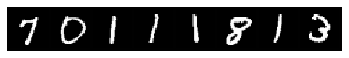

e 90, step 226000, loss 0.4892371892929077
Target:	 tensor([5, 0, 4, 7, 8, 8, 6, 6], device='cuda:0')
Pred:	 tensor([5, 0, 8, 7, 8, 8, 6, 6], device='cuda:0')


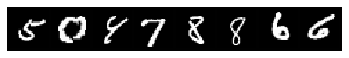

e 91, step 228000, loss 0.2625042796134949
Target:	 tensor([8, 0, 7, 2, 5, 4, 0, 5], device='cuda:0')
Pred:	 tensor([8, 0, 1, 2, 5, 4, 0, 5], device='cuda:0')


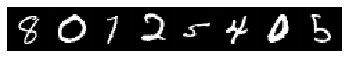

e 92, step 230000, loss 0.2328953891992569
Target:	 tensor([3, 1, 2, 4, 7, 2, 8, 2], device='cuda:0')
Pred:	 tensor([3, 1, 2, 4, 7, 2, 8, 2], device='cuda:0')


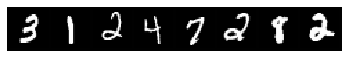

e 92, step 232000, loss 0.22881978750228882
Target:	 tensor([3, 3, 7, 0, 3, 1, 1, 1], device='cuda:0')
Pred:	 tensor([3, 3, 7, 0, 3, 1, 1, 1], device='cuda:0')


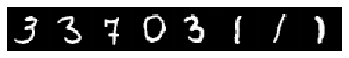

e 93, step 234000, loss 0.18785811960697174
Target:	 tensor([8, 6, 5, 7, 5, 8, 0, 9], device='cuda:0')
Pred:	 tensor([8, 6, 5, 7, 5, 8, 0, 9], device='cuda:0')


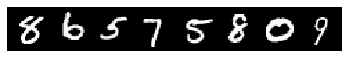

e 94, step 236000, loss 0.2069055736064911
Target:	 tensor([0, 5, 4, 2, 7, 6, 5, 6], device='cuda:0')
Pred:	 tensor([0, 5, 4, 2, 7, 6, 5, 6], device='cuda:0')


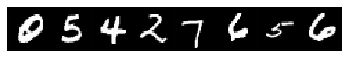

e 95, step 238000, loss 0.23149007558822632
Target:	 tensor([6, 0, 6, 1, 0, 5, 0, 3], device='cuda:0')
Pred:	 tensor([6, 0, 6, 1, 0, 5, 0, 3], device='cuda:0')


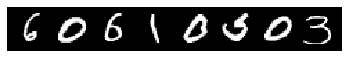

e 96, step 240000, loss 0.20913715660572052
Target:	 tensor([1, 2, 0, 0, 5, 0, 3, 5], device='cuda:0')
Pred:	 tensor([1, 2, 0, 0, 5, 0, 3, 5], device='cuda:0')


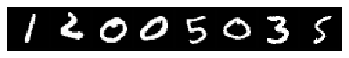

e 96, step 242000, loss 0.20399980247020721
Target:	 tensor([6, 6, 9, 7, 9, 6, 0, 2], device='cuda:0')
Pred:	 tensor([6, 6, 9, 7, 9, 6, 0, 2], device='cuda:0')


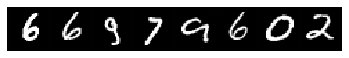

e 97, step 244000, loss 0.225369393825531
Target:	 tensor([0, 6, 6, 5, 7, 9, 1, 5], device='cuda:0')
Pred:	 tensor([0, 6, 6, 5, 7, 9, 1, 5], device='cuda:0')


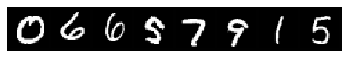

e 98, step 246000, loss 0.24798017740249634
Target:	 tensor([3, 6, 0, 7, 6, 5, 0, 4], device='cuda:0')
Pred:	 tensor([3, 6, 0, 7, 6, 5, 0, 4], device='cuda:0')


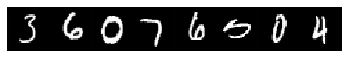

e 99, step 248000, loss 0.19269657135009766
Target:	 tensor([2, 1, 3, 0, 0, 1, 7, 4], device='cuda:0')
Pred:	 tensor([2, 1, 3, 0, 0, 1, 7, 4], device='cuda:0')


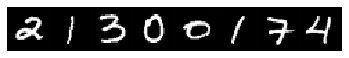

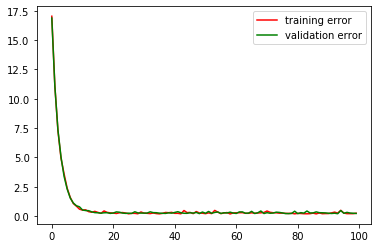

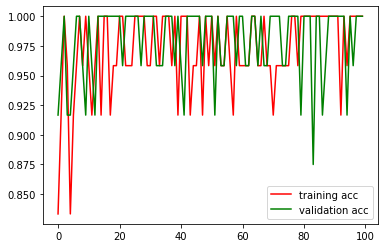

In [24]:
################################################################################################################################
# Training script
# learning rate, hyper-parameter
lr = 1e-3

# using GPU if it's availble
device = torch.device('cuda')

net = LeNetDrop(img_channel, device)
# keep a list of moel parameters
params = [p for (n, p) in net.named_parameters()]

# training epochs, hyper-parameter
epochs = 100

# keep tracking of the changing of loss and accuracy of predictions
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
print_interval = 2000
for e in range(epochs):
  net.train()
  for i, (imgs, lbs) in enumerate(train_dl):
    imgs = imgs.to(device)
    lbs = lbs.to(device)
    loss, prob = net(imgs, lbs, training=True)
     # add the weight decay penalty to the loss  
    lamb = 2.0   
    loss = weight_decay(loss, params, lamb, lbs.shape[0])
    
    net.zero_grad()
    grad = torch.autograd.grad(loss, params)
    
    # update weights
    step(params, grad, lr)
    
    # obtain the predictions
    pred = prob.argmax(dim=-1).view(batch_size)
    acc = (pred == lbs).float().mean()
    if (i + e*len(train_dl)) % print_interval == 0:
      print("e {}, step {}, loss {}".format( e, i + e*len(train_dl), loss))
      print("Target:\t {}\nPred:\t {}".format(lbs[:8], pred[:8]))
      # visualize some samples
      imgs_to_vis = vutils.make_grid(imgs[:8].cpu()+125., nrow=8, pad_value=1)
      plt.imshow(imgs_to_vis.permute(1,2,0).numpy().astype(np.uint8))
      plt.axis("off")
      plt.show()   
  train_loss_list.append(loss.detach().mean())
  train_acc_list.append(acc.detach().mean())
  
  net.eval()
  for i, (imgs, lbs) in enumerate(val_dl):
    imgs = imgs.to(device)
    lbs = lbs.to(device)
    loss, prob = net(imgs, lbs, False)
    # add the weight decay penalty to the loss  
    lamb = 2.0   
    loss = weight_decay(loss, params, lamb, lbs.shape[0])   
    
    pred = prob.argmax(dim=-1).view(batch_size)
    acc = (pred == lbs).float().mean()
    
  val_loss_list.append(loss.detach().mean())
  val_acc_list.append(acc.detach().mean())
  

# ploting logs
plt.plot(np.arange(epochs), train_loss_list, '-r',
         np.arange(epochs), val_loss_list, '-g')
plt.legend(('training error', 'validation error'))
plt.show()
plt.plot(np.arange(epochs), train_acc_list, '-r',
         np.arange(epochs), val_acc_list, '-g')
plt.legend(('training acc', 'validation acc'))
plt.show()

## Batch Normalization

[Batch Normalization](https://arxiv.org/pdf/1502.03167.pdf) can accelerate the training procedure by shifting and scaling the input for each layer. 

**To-do**:
    - (10 points)Complete the **batch_norm_forward()** function for class BatchNorm.
    - (5 points)Modify the class LeNetDrop to class LeNetDropNorm: add a batch normalization layer after layer each dropout layer for LeNetDrop. 
    - Write the dataset loading script, training script for LeNetDropNorm.
    - Train LeNetDropNorm on the full MNIST dataset.
    - (10 points)Plot out the training loss curve, validation loss curve, training accuracy curve and validation accuracy curve.

In [25]:
class BatchNorm(nn.Module):
  def __init__(self, num_features, device, eps=1e-5):
    super(BatchNorm, self).__init__()
    self.gamma = nn.Parameter(torch.ones(num_features, dtype=torch.float32, device=device), requires_grad=True)
    self.beta = nn.Parameter(torch.zeros(num_features, dtype=torch.float32, device=device), requires_grad=True)
    self.moving_mean = 0.
    self.moving_var = 0.
    self.eps = eps
    self.num_features = num_features
    self.device = device
    
  def batch_norm_forward(self, x, training=True):
    """
    input:
      X: (N, *), input of dropout layer, where N is the batch size
    output:
      Y: (N, *), where N is the batch size
    """
    ### Start the code here  ###
    if training:
        if len(x.shape) == 2:
            mean = x.mean(0).unsqueeze(0).expand_as(x).cuda()
            var = ((x-mean)**2).mean(0).unsqueeze(0).expand_as(x).cuda()
        else:
            mean = x.mean(-1).mean(-1).mean(0).unsqueeze(-1).unsqueeze(-1).unsqueeze(0).expand_as(x).to(self.device)
            var = ((x-mean)**2).mean(-1).mean(-1).mean(0).unsqueeze(-1).unsqueeze(-1).unsqueeze(0).expand_as(x).to(self.device)
        x_hat = (x-mean) / (var + self.eps)**(0.5)
        momentum = 0.95
        self.moving_mean = momentum*self.moving_mean+(1-momentum)*mean
        self.moving_var = momentum*self.moving_var+(1-momentum)*var
    else:
        x_hat = (x - self.moving_mean) / (self.moving_var + self.eps)**0.5
        
    Y = self.gamma*x_hat.cuda() + self.beta.cuda()
    ###  End of the code ###
    
    return Y
    
  def forward(self, inputs, training=True):
    return self.batch_norm_forward(inputs, training)

In [26]:
# dataset loading, training script and other codes starts here:
# LeNetDrop sketch code
class LeNetDropNorm(nn.Module):
  def __init__(self, img_c, device):
    super(LeNetDropNorm, self).__init__()
    drop_p = 0.2
    self.c1 = Conv2D(img_c, 6, [5,5], [1,1], [2,2,2,2], device)
    self.d1 = Dropout(drop_p, device)
    self.n1 = BatchNorm([1, 6, 1, 1], device)

    self.p2 = nn.MaxPool2d(2, stride=2)
    self.c3 = Conv2D(6, 16, [5,5], [1,1], [0,0,0,0], device)
    self.d3 = Dropout(drop_p, device)
    self.n3 = BatchNorm([1, 16, 1, 1], device)
    
    self.p4 = nn.MaxPool2d(2, stride=2)
    self.f5 = Linear(400, 120, device)
    self.d5 = Dropout(drop_p, device)
    self.n5 = BatchNorm([1,120], device)
    
    self.f6 = Linear(120, 84, device)
    self.f7 = Linear(84, 10, device)
    self.device = device
    
  def forward(self, imgs, labels, training=True):
    """
    inputs:
      imgs: (N, C, H, W), training samples from the MNIST training set, where N is the number of samples (batch_size),
          C is the image color channle number, H and W are the spatial size of the input images.
      labels: (N, L), ground truth for the input images, where N is the number of samples (batch_size) and L is the 
          number of classes.
    outputs:
      loss: (1,), mean loss value over this batch of inputs.
    
    """
    N = imgs.shape[0]
    
    o_c1 = F.relu(self.c1(imgs))
    o_d1 = self.d1(o_c1, training)
    o_n1 = self.n1(o_d1, training)
    
    o_p2 = self.p2(o_n1)
    o_c3 = F.relu(self.c3(o_p2))
    o_d3 = self.d3(o_c3, training)
    o_n3 = self.n3(o_d3, training)
    
    o_p4 = self.p4(o_n3)
    
    ### Start the code here  ###
    # 1. Please complete the rest of LeNet to get the scores predicted by LeNet for each input images #
    # need to flatten the matrix before forwarding to the dense layer    
    o_f5 = F.relu(self.f5(o_p4.reshape(o_p4.shape[0], -1)))
    o_d5 = self.d5(o_f5, training)
    o_n5 = self.n5(o_d5, training)
    
    o_f6 = F.relu(self.f6(o_n5))
    o_f7 = self.f7(o_f6)
    # 2. Please use the implemented objective function to obtain the losses of each input. #
    p = softmax1d(o_f7)  
    # 3. We will return the mean value of the losses. #
    loss = cross_entropy_loss(p, labels)
    ###  End of the code ###
    return loss.mean(), p

In [27]:
################################################################################################################################
# Train LeNetDrop on the full dataset
################################################################################################################################
# Dataset loading script
train_ds = MNISTDataset(60000, split = "training")
val_ds = MNISTDataset(10000, split = "validation")

# training batch size, hyper-parameter
batch_size = 24

# dataset loader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, drop_last=True)
img_channel = 1

e 0, step 0, loss 34.09567642211914
Target:	 tensor([3, 3, 9, 2, 9, 2, 7, 4], device='cuda:0')
Pred:	 tensor([0, 5, 5, 6, 6, 6, 6, 5], device='cuda:0')


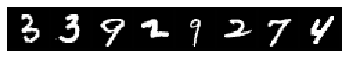

e 0, step 2000, loss 24.14310646057129
Target:	 tensor([0, 8, 1, 7, 6, 6, 9, 7], device='cuda:0')
Pred:	 tensor([0, 8, 1, 7, 6, 6, 9, 7], device='cuda:0')


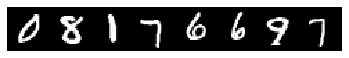

e 1, step 4000, loss 17.499126434326172
Target:	 tensor([5, 6, 7, 7, 7, 8, 7, 5], device='cuda:0')
Pred:	 tensor([5, 6, 7, 7, 7, 3, 7, 9], device='cuda:0')


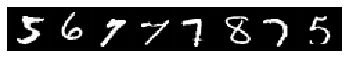

e 2, step 6000, loss 12.942313194274902
Target:	 tensor([4, 4, 1, 2, 2, 8, 0, 3], device='cuda:0')
Pred:	 tensor([4, 6, 1, 2, 2, 8, 0, 3], device='cuda:0')


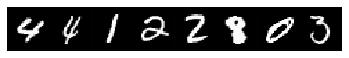

e 3, step 8000, loss 9.888056755065918
Target:	 tensor([1, 3, 5, 4, 3, 0, 3, 8], device='cuda:0')
Pred:	 tensor([1, 5, 5, 4, 7, 0, 9, 8], device='cuda:0')


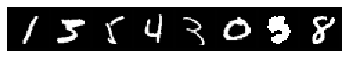

e 4, step 10000, loss 7.5098466873168945
Target:	 tensor([0, 8, 9, 8, 9, 5, 1, 5], device='cuda:0')
Pred:	 tensor([0, 8, 9, 8, 9, 5, 1, 5], device='cuda:0')


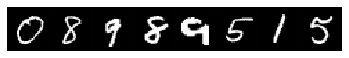

e 4, step 12000, loss 5.929827690124512
Target:	 tensor([1, 4, 2, 0, 7, 8, 7, 6], device='cuda:0')
Pred:	 tensor([1, 4, 2, 0, 7, 8, 7, 6], device='cuda:0')


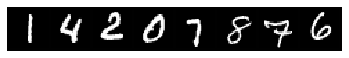

e 5, step 14000, loss 4.685754776000977
Target:	 tensor([1, 5, 3, 2, 2, 3, 8, 2], device='cuda:0')
Pred:	 tensor([1, 5, 3, 2, 2, 3, 8, 2], device='cuda:0')


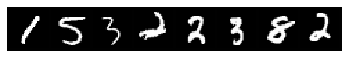

e 6, step 16000, loss 3.9934871196746826
Target:	 tensor([9, 7, 7, 6, 3, 8, 0, 8], device='cuda:0')
Pred:	 tensor([5, 7, 7, 6, 3, 8, 0, 8], device='cuda:0')


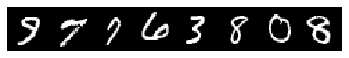

e 7, step 18000, loss 3.1930806636810303
Target:	 tensor([0, 8, 7, 3, 3, 4, 3, 7], device='cuda:0')
Pred:	 tensor([0, 8, 7, 3, 3, 4, 3, 7], device='cuda:0')


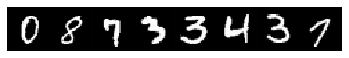

e 8, step 20000, loss 2.853916645050049
Target:	 tensor([8, 0, 2, 3, 7, 4, 6, 5], device='cuda:0')
Pred:	 tensor([8, 0, 2, 3, 7, 4, 6, 5], device='cuda:0')


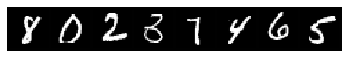

e 8, step 22000, loss 2.6965689659118652
Target:	 tensor([4, 6, 0, 0, 6, 8, 2, 4], device='cuda:0')
Pred:	 tensor([4, 6, 0, 0, 6, 8, 2, 4], device='cuda:0')


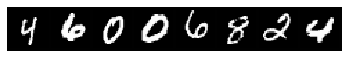

e 9, step 24000, loss 2.5419158935546875
Target:	 tensor([9, 0, 4, 4, 1, 3, 9, 2], device='cuda:0')
Pred:	 tensor([9, 0, 4, 9, 1, 3, 9, 2], device='cuda:0')


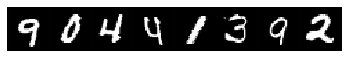

e 10, step 26000, loss 2.250012159347534
Target:	 tensor([3, 3, 5, 3, 8, 8, 2, 0], device='cuda:0')
Pred:	 tensor([3, 3, 5, 3, 3, 8, 2, 0], device='cuda:0')


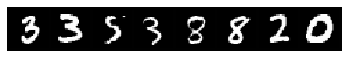

e 11, step 28000, loss 2.0988266468048096
Target:	 tensor([2, 3, 3, 5, 5, 9, 0, 5], device='cuda:0')
Pred:	 tensor([2, 3, 3, 5, 5, 9, 0, 5], device='cuda:0')


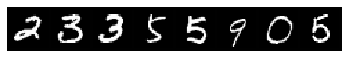

e 12, step 30000, loss 2.118147134780884
Target:	 tensor([4, 8, 9, 3, 0, 1, 2, 7], device='cuda:0')
Pred:	 tensor([4, 8, 9, 3, 5, 1, 2, 7], device='cuda:0')


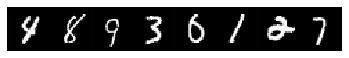

e 12, step 32000, loss 1.9780573844909668
Target:	 tensor([8, 5, 4, 5, 2, 7, 3, 3], device='cuda:0')
Pred:	 tensor([8, 5, 4, 5, 2, 7, 3, 3], device='cuda:0')


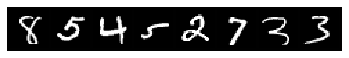

e 13, step 34000, loss 1.923034906387329
Target:	 tensor([3, 0, 0, 5, 7, 0, 1, 4], device='cuda:0')
Pred:	 tensor([3, 0, 0, 5, 7, 0, 1, 4], device='cuda:0')


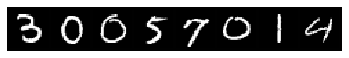

e 14, step 36000, loss 1.8998757600784302
Target:	 tensor([7, 6, 9, 9, 1, 2, 4, 2], device='cuda:0')
Pred:	 tensor([7, 6, 9, 9, 1, 2, 4, 2], device='cuda:0')


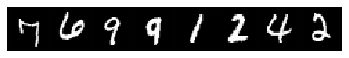

e 15, step 38000, loss 1.895589828491211
Target:	 tensor([8, 4, 7, 9, 8, 1, 8, 7], device='cuda:0')
Pred:	 tensor([8, 4, 7, 9, 8, 1, 8, 2], device='cuda:0')


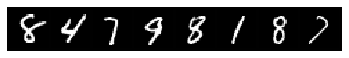

e 16, step 40000, loss 1.861626148223877
Target:	 tensor([3, 2, 0, 4, 2, 6, 8, 9], device='cuda:0')
Pred:	 tensor([3, 2, 0, 4, 2, 6, 8, 9], device='cuda:0')


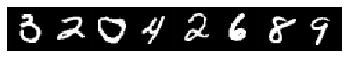

e 16, step 42000, loss 1.9671578407287598
Target:	 tensor([9, 6, 5, 3, 8, 8, 6, 5], device='cuda:0')
Pred:	 tensor([9, 6, 5, 3, 8, 8, 6, 5], device='cuda:0')


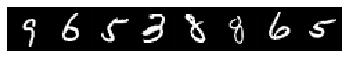

e 17, step 44000, loss 1.909401535987854
Target:	 tensor([2, 6, 5, 0, 0, 2, 9, 8], device='cuda:0')
Pred:	 tensor([2, 6, 5, 0, 0, 2, 9, 8], device='cuda:0')


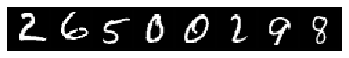

e 18, step 46000, loss 1.8024046421051025
Target:	 tensor([6, 1, 1, 0, 0, 9, 9, 2], device='cuda:0')
Pred:	 tensor([6, 1, 1, 0, 0, 9, 9, 2], device='cuda:0')


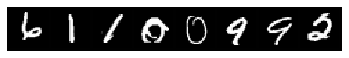

e 19, step 48000, loss 1.8529415130615234
Target:	 tensor([9, 2, 6, 7, 3, 9, 5, 2], device='cuda:0')
Pred:	 tensor([9, 2, 6, 7, 3, 9, 5, 2], device='cuda:0')


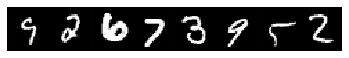

e 20, step 50000, loss 1.8549593687057495
Target:	 tensor([4, 4, 1, 1, 9, 1, 3, 3], device='cuda:0')
Pred:	 tensor([4, 4, 1, 1, 9, 1, 3, 3], device='cuda:0')


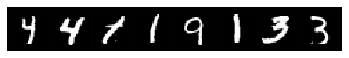

e 20, step 52000, loss 1.8605475425720215
Target:	 tensor([1, 1, 7, 0, 2, 5, 8, 4], device='cuda:0')
Pred:	 tensor([1, 1, 7, 0, 2, 5, 8, 4], device='cuda:0')


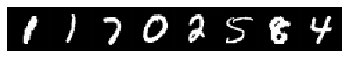

e 21, step 54000, loss 1.8667407035827637
Target:	 tensor([1, 8, 4, 4, 8, 2, 3, 8], device='cuda:0')
Pred:	 tensor([1, 8, 4, 4, 8, 2, 3, 8], device='cuda:0')


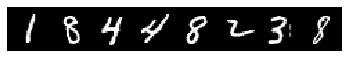

e 22, step 56000, loss 1.976410984992981
Target:	 tensor([5, 6, 9, 8, 7, 8, 1, 4], device='cuda:0')
Pred:	 tensor([3, 6, 9, 8, 7, 8, 1, 4], device='cuda:0')


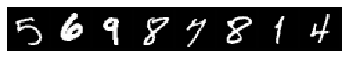

e 23, step 58000, loss 1.7720621824264526
Target:	 tensor([7, 8, 5, 6, 4, 7, 5, 8], device='cuda:0')
Pred:	 tensor([7, 8, 5, 6, 4, 7, 5, 8], device='cuda:0')


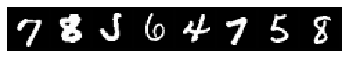

e 24, step 60000, loss 1.8417295217514038
Target:	 tensor([8, 3, 4, 5, 2, 1, 2, 0], device='cuda:0')
Pred:	 tensor([8, 3, 4, 5, 2, 1, 2, 0], device='cuda:0')


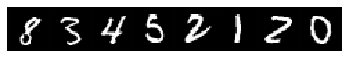

e 24, step 62000, loss 1.8653018474578857
Target:	 tensor([5, 5, 3, 4, 3, 5, 8, 4], device='cuda:0')
Pred:	 tensor([5, 5, 3, 4, 3, 5, 8, 4], device='cuda:0')


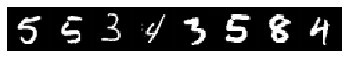

e 25, step 64000, loss 1.8613054752349854
Target:	 tensor([1, 4, 2, 1, 5, 9, 2, 6], device='cuda:0')
Pred:	 tensor([1, 9, 2, 1, 5, 9, 2, 6], device='cuda:0')


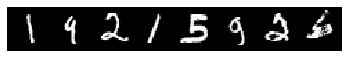

e 26, step 66000, loss 1.9290931224822998
Target:	 tensor([9, 5, 1, 0, 4, 9, 1, 0], device='cuda:0')
Pred:	 tensor([9, 5, 1, 0, 4, 9, 1, 0], device='cuda:0')


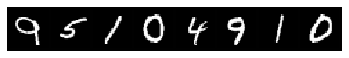

e 27, step 68000, loss 1.7754411697387695
Target:	 tensor([3, 8, 8, 3, 0, 0, 2, 2], device='cuda:0')
Pred:	 tensor([3, 8, 8, 3, 0, 0, 2, 2], device='cuda:0')


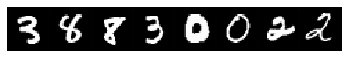

e 28, step 70000, loss 1.8111956119537354
Target:	 tensor([0, 2, 0, 4, 1, 4, 9, 1], device='cuda:0')
Pred:	 tensor([0, 2, 0, 4, 1, 4, 9, 1], device='cuda:0')


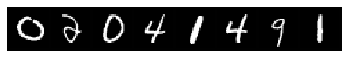

e 28, step 72000, loss 1.7836768627166748
Target:	 tensor([5, 3, 0, 2, 3, 4, 2, 1], device='cuda:0')
Pred:	 tensor([5, 3, 0, 2, 3, 4, 2, 1], device='cuda:0')


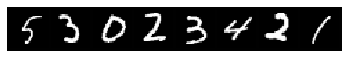

e 29, step 74000, loss 1.9323554039001465
Target:	 tensor([2, 6, 6, 2, 9, 2, 4, 5], device='cuda:0')
Pred:	 tensor([2, 6, 6, 2, 9, 2, 4, 5], device='cuda:0')


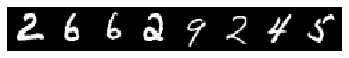

e 30, step 76000, loss 1.801836371421814
Target:	 tensor([3, 6, 9, 5, 3, 8, 3, 7], device='cuda:0')
Pred:	 tensor([3, 6, 9, 5, 3, 8, 3, 7], device='cuda:0')


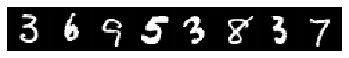

e 31, step 78000, loss 1.8318942785263062
Target:	 tensor([9, 5, 4, 2, 2, 9, 0, 7], device='cuda:0')
Pred:	 tensor([9, 5, 4, 2, 2, 9, 0, 7], device='cuda:0')


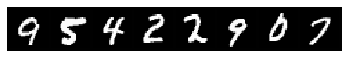

e 32, step 80000, loss 1.8156256675720215
Target:	 tensor([9, 2, 0, 9, 1, 7, 6, 5], device='cuda:0')
Pred:	 tensor([9, 2, 0, 9, 1, 7, 6, 5], device='cuda:0')


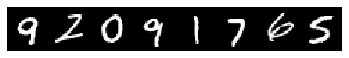

e 32, step 82000, loss 1.8436275720596313
Target:	 tensor([5, 6, 3, 8, 1, 1, 4, 0], device='cuda:0')
Pred:	 tensor([5, 6, 3, 8, 2, 1, 9, 0], device='cuda:0')


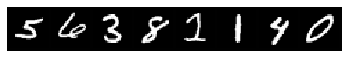

e 33, step 84000, loss 1.8119051456451416
Target:	 tensor([3, 4, 7, 4, 1, 2, 6, 3], device='cuda:0')
Pred:	 tensor([3, 4, 7, 4, 1, 2, 6, 3], device='cuda:0')


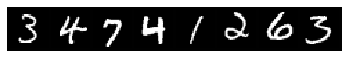

e 34, step 86000, loss 1.8797708749771118
Target:	 tensor([2, 9, 3, 2, 5, 2, 6, 3], device='cuda:0')
Pred:	 tensor([2, 9, 3, 2, 5, 2, 6, 3], device='cuda:0')


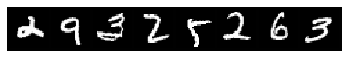

e 35, step 88000, loss 1.8763177394866943
Target:	 tensor([3, 6, 2, 0, 5, 5, 4, 6], device='cuda:0')
Pred:	 tensor([3, 6, 2, 0, 5, 5, 4, 6], device='cuda:0')


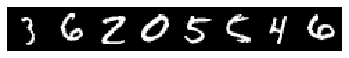

e 36, step 90000, loss 1.8664355278015137
Target:	 tensor([3, 7, 2, 3, 4, 8, 8, 4], device='cuda:0')
Pred:	 tensor([3, 7, 2, 3, 4, 8, 8, 4], device='cuda:0')


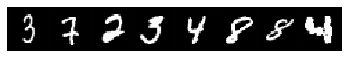

e 36, step 92000, loss 1.802858829498291
Target:	 tensor([1, 4, 3, 6, 9, 5, 0, 5], device='cuda:0')
Pred:	 tensor([7, 4, 3, 6, 9, 5, 0, 5], device='cuda:0')


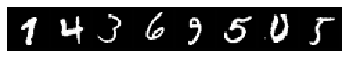

e 37, step 94000, loss 1.8296282291412354
Target:	 tensor([8, 5, 4, 5, 9, 0, 8, 2], device='cuda:0')
Pred:	 tensor([8, 5, 4, 5, 9, 0, 8, 2], device='cuda:0')


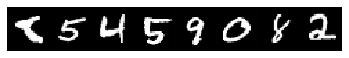

e 38, step 96000, loss 1.7463901042938232
Target:	 tensor([8, 0, 8, 5, 4, 1, 6, 9], device='cuda:0')
Pred:	 tensor([8, 0, 8, 5, 4, 1, 6, 9], device='cuda:0')


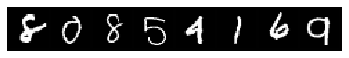

e 39, step 98000, loss 1.809220790863037
Target:	 tensor([3, 7, 4, 9, 6, 1, 3, 0], device='cuda:0')
Pred:	 tensor([3, 7, 4, 9, 6, 1, 3, 0], device='cuda:0')


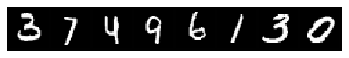

e 40, step 100000, loss 1.855083703994751
Target:	 tensor([6, 0, 4, 2, 0, 4, 6, 0], device='cuda:0')
Pred:	 tensor([6, 0, 4, 2, 0, 4, 6, 0], device='cuda:0')


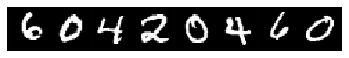

e 40, step 102000, loss 1.7687714099884033
Target:	 tensor([5, 6, 2, 1, 1, 2, 0, 4], device='cuda:0')
Pred:	 tensor([5, 6, 2, 1, 1, 2, 0, 4], device='cuda:0')


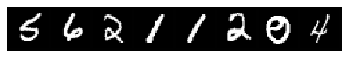

e 41, step 104000, loss 1.8525516986846924
Target:	 tensor([9, 1, 0, 0, 5, 6, 1, 0], device='cuda:0')
Pred:	 tensor([9, 1, 0, 0, 5, 6, 1, 0], device='cuda:0')


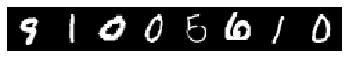

e 42, step 106000, loss 1.9518128633499146
Target:	 tensor([3, 9, 8, 1, 8, 3, 8, 0], device='cuda:0')
Pred:	 tensor([3, 9, 8, 1, 8, 3, 8, 0], device='cuda:0')


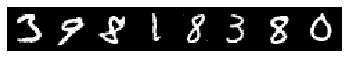

e 43, step 108000, loss 1.860915184020996
Target:	 tensor([1, 0, 2, 7, 1, 9, 3, 6], device='cuda:0')
Pred:	 tensor([1, 0, 2, 7, 1, 9, 3, 6], device='cuda:0')


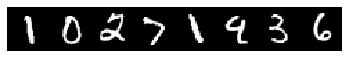

e 44, step 110000, loss 1.7896907329559326
Target:	 tensor([1, 1, 4, 3, 2, 1, 7, 6], device='cuda:0')
Pred:	 tensor([1, 1, 4, 3, 2, 1, 7, 6], device='cuda:0')


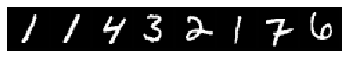

e 44, step 112000, loss 1.9111802577972412
Target:	 tensor([3, 2, 7, 0, 1, 5, 8, 1], device='cuda:0')
Pred:	 tensor([3, 2, 7, 0, 1, 5, 8, 1], device='cuda:0')


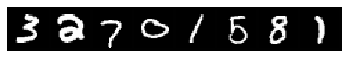

e 45, step 114000, loss 1.831419825553894
Target:	 tensor([1, 0, 2, 4, 1, 0, 0, 3], device='cuda:0')
Pred:	 tensor([1, 0, 2, 4, 1, 0, 0, 3], device='cuda:0')


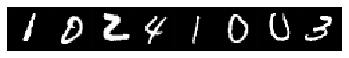

e 46, step 116000, loss 1.7968449592590332
Target:	 tensor([0, 7, 2, 9, 2, 3, 0, 7], device='cuda:0')
Pred:	 tensor([0, 7, 2, 9, 2, 3, 0, 7], device='cuda:0')


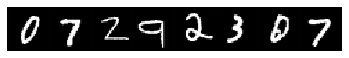

e 47, step 118000, loss 1.8440544605255127
Target:	 tensor([9, 0, 3, 1, 5, 1, 0, 0], device='cuda:0')
Pred:	 tensor([9, 0, 3, 1, 5, 1, 0, 0], device='cuda:0')


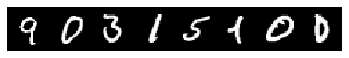

e 48, step 120000, loss 1.8538726568222046
Target:	 tensor([6, 5, 4, 4, 9, 7, 1, 5], device='cuda:0')
Pred:	 tensor([6, 8, 4, 4, 9, 7, 1, 5], device='cuda:0')


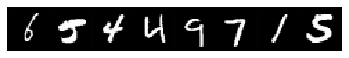

e 48, step 122000, loss 1.8428013324737549
Target:	 tensor([4, 2, 2, 9, 2, 4, 6, 3], device='cuda:0')
Pred:	 tensor([4, 2, 2, 9, 2, 4, 6, 3], device='cuda:0')


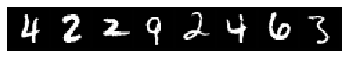

e 49, step 124000, loss 1.7825195789337158
Target:	 tensor([5, 6, 5, 0, 9, 7, 5, 2], device='cuda:0')
Pred:	 tensor([5, 6, 5, 0, 9, 7, 5, 2], device='cuda:0')


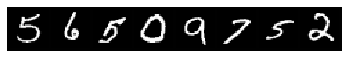

e 50, step 126000, loss 1.8047479391098022
Target:	 tensor([4, 0, 4, 3, 7, 8, 1, 4], device='cuda:0')
Pred:	 tensor([4, 0, 4, 3, 7, 8, 1, 4], device='cuda:0')


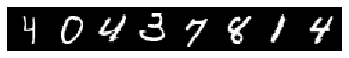

e 51, step 128000, loss 1.7868151664733887
Target:	 tensor([3, 9, 0, 3, 6, 5, 0, 8], device='cuda:0')
Pred:	 tensor([3, 9, 0, 3, 6, 5, 0, 8], device='cuda:0')


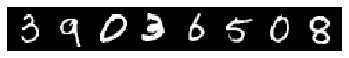

e 52, step 130000, loss 1.7983767986297607
Target:	 tensor([7, 9, 9, 3, 0, 8, 7, 0], device='cuda:0')
Pred:	 tensor([7, 9, 9, 3, 0, 8, 7, 0], device='cuda:0')


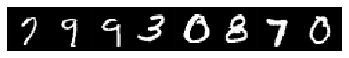

e 52, step 132000, loss 1.8953509330749512
Target:	 tensor([0, 5, 0, 1, 7, 3, 8, 2], device='cuda:0')
Pred:	 tensor([0, 5, 0, 1, 7, 3, 9, 2], device='cuda:0')


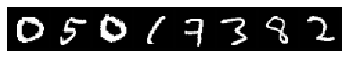

e 53, step 134000, loss 1.9458274841308594
Target:	 tensor([0, 1, 9, 6, 0, 5, 3, 4], device='cuda:0')
Pred:	 tensor([7, 1, 9, 6, 0, 5, 3, 4], device='cuda:0')


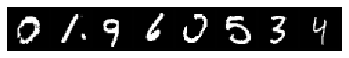

e 54, step 136000, loss 1.8445227146148682
Target:	 tensor([8, 3, 5, 5, 5, 4, 3, 6], device='cuda:0')
Pred:	 tensor([8, 3, 5, 5, 5, 4, 3, 6], device='cuda:0')


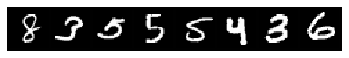

e 55, step 138000, loss 1.7595453262329102
Target:	 tensor([1, 1, 3, 2, 1, 5, 5, 6], device='cuda:0')
Pred:	 tensor([1, 1, 3, 2, 1, 5, 5, 6], device='cuda:0')


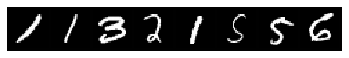

e 56, step 140000, loss 1.8456008434295654
Target:	 tensor([7, 8, 8, 9, 2, 5, 5, 8], device='cuda:0')
Pred:	 tensor([7, 8, 8, 9, 2, 5, 5, 8], device='cuda:0')


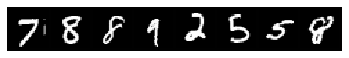

e 56, step 142000, loss 1.7782552242279053
Target:	 tensor([8, 6, 0, 7, 1, 4, 0, 7], device='cuda:0')
Pred:	 tensor([8, 6, 0, 7, 1, 4, 0, 7], device='cuda:0')


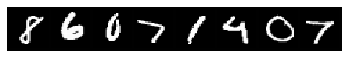

e 57, step 144000, loss 1.7855638265609741
Target:	 tensor([5, 5, 2, 1, 2, 5, 6, 9], device='cuda:0')
Pred:	 tensor([5, 5, 2, 1, 2, 5, 6, 9], device='cuda:0')


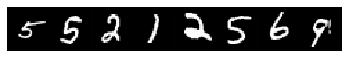

e 58, step 146000, loss 1.7774146795272827
Target:	 tensor([8, 1, 9, 2, 7, 1, 8, 3], device='cuda:0')
Pred:	 tensor([8, 1, 9, 2, 7, 1, 8, 3], device='cuda:0')


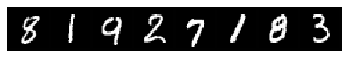

e 59, step 148000, loss 1.7669554948806763
Target:	 tensor([9, 1, 9, 9, 1, 0, 0, 8], device='cuda:0')
Pred:	 tensor([9, 1, 9, 9, 1, 0, 0, 8], device='cuda:0')


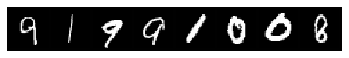

e 60, step 150000, loss 1.7614527940750122
Target:	 tensor([6, 9, 7, 8, 1, 9, 1, 3], device='cuda:0')
Pred:	 tensor([6, 9, 7, 8, 1, 9, 1, 3], device='cuda:0')


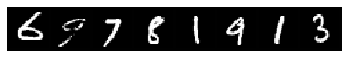

e 60, step 152000, loss 1.7723456621170044
Target:	 tensor([2, 2, 3, 7, 7, 4, 4, 5], device='cuda:0')
Pred:	 tensor([2, 2, 3, 7, 7, 4, 4, 5], device='cuda:0')


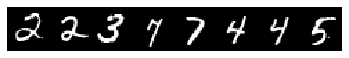

e 61, step 154000, loss 1.8009408712387085
Target:	 tensor([2, 3, 9, 7, 6, 7, 4, 5], device='cuda:0')
Pred:	 tensor([2, 3, 9, 7, 6, 7, 4, 5], device='cuda:0')


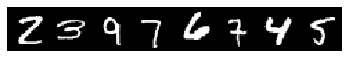

e 62, step 156000, loss 1.8101850748062134
Target:	 tensor([2, 3, 8, 3, 7, 6, 8, 4], device='cuda:0')
Pred:	 tensor([2, 3, 8, 3, 7, 6, 8, 4], device='cuda:0')


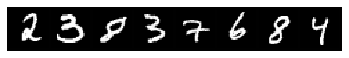

e 63, step 158000, loss 1.8040566444396973
Target:	 tensor([7, 6, 8, 3, 3, 7, 6, 3], device='cuda:0')
Pred:	 tensor([7, 6, 8, 3, 3, 7, 6, 3], device='cuda:0')


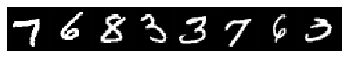

e 64, step 160000, loss 1.8481130599975586
Target:	 tensor([5, 9, 4, 8, 2, 0, 3, 2], device='cuda:0')
Pred:	 tensor([5, 7, 4, 8, 2, 0, 3, 2], device='cuda:0')


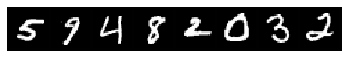

e 64, step 162000, loss 1.802116870880127
Target:	 tensor([5, 7, 1, 5, 7, 6, 2, 7], device='cuda:0')
Pred:	 tensor([5, 7, 1, 5, 7, 6, 2, 7], device='cuda:0')


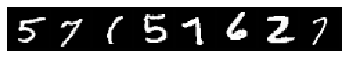

e 65, step 164000, loss 1.7994961738586426
Target:	 tensor([7, 5, 6, 9, 4, 5, 5, 5], device='cuda:0')
Pred:	 tensor([7, 5, 6, 9, 4, 5, 5, 5], device='cuda:0')


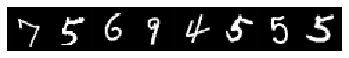

e 66, step 166000, loss 1.821411371231079
Target:	 tensor([8, 0, 9, 2, 9, 5, 9, 6], device='cuda:0')
Pred:	 tensor([8, 0, 4, 2, 9, 5, 9, 6], device='cuda:0')


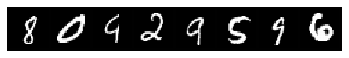

e 67, step 168000, loss 1.8479673862457275
Target:	 tensor([0, 7, 1, 1, 3, 6, 0, 0], device='cuda:0')
Pred:	 tensor([0, 7, 1, 1, 3, 6, 0, 0], device='cuda:0')


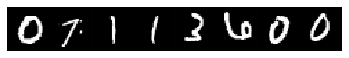

e 68, step 170000, loss 1.9464595317840576
Target:	 tensor([0, 7, 8, 8, 7, 3, 1, 8], device='cuda:0')
Pred:	 tensor([0, 2, 8, 6, 7, 3, 1, 8], device='cuda:0')


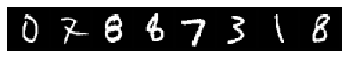

e 68, step 172000, loss 1.8212069272994995
Target:	 tensor([3, 4, 4, 1, 2, 6, 9, 6], device='cuda:0')
Pred:	 tensor([3, 4, 4, 1, 2, 6, 9, 6], device='cuda:0')


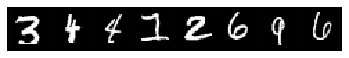

e 69, step 174000, loss 1.8676215410232544
Target:	 tensor([5, 7, 1, 0, 2, 5, 6, 3], device='cuda:0')
Pred:	 tensor([5, 7, 1, 0, 2, 5, 6, 3], device='cuda:0')


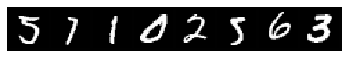

e 70, step 176000, loss 1.738046646118164
Target:	 tensor([6, 4, 4, 8, 3, 1, 9, 7], device='cuda:0')
Pred:	 tensor([6, 4, 4, 8, 3, 1, 9, 7], device='cuda:0')


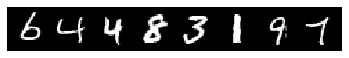

e 71, step 178000, loss 1.846350908279419
Target:	 tensor([0, 3, 7, 3, 2, 3, 2, 5], device='cuda:0')
Pred:	 tensor([0, 3, 7, 3, 2, 3, 2, 5], device='cuda:0')


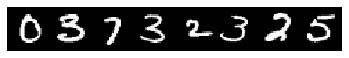

e 72, step 180000, loss 1.8458359241485596
Target:	 tensor([6, 8, 2, 8, 5, 1, 6, 0], device='cuda:0')
Pred:	 tensor([6, 8, 2, 8, 5, 1, 6, 0], device='cuda:0')


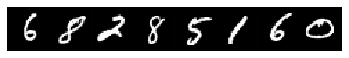

e 72, step 182000, loss 1.8131740093231201
Target:	 tensor([8, 8, 2, 3, 7, 3, 7, 2], device='cuda:0')
Pred:	 tensor([8, 8, 2, 3, 7, 3, 7, 2], device='cuda:0')


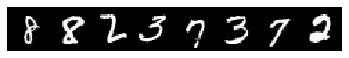

e 73, step 184000, loss 1.7366836071014404
Target:	 tensor([4, 9, 2, 7, 4, 9, 6, 6], device='cuda:0')
Pred:	 tensor([4, 9, 2, 7, 4, 9, 6, 6], device='cuda:0')


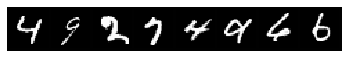

e 74, step 186000, loss 1.7867136001586914
Target:	 tensor([5, 6, 5, 8, 7, 6, 4, 2], device='cuda:0')
Pred:	 tensor([5, 6, 5, 8, 7, 6, 4, 2], device='cuda:0')


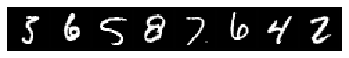

e 75, step 188000, loss 1.8313355445861816
Target:	 tensor([2, 7, 5, 8, 4, 8, 9, 1], device='cuda:0')
Pred:	 tensor([2, 7, 5, 8, 4, 8, 9, 1], device='cuda:0')


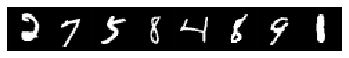

e 76, step 190000, loss 1.7501091957092285
Target:	 tensor([7, 0, 0, 3, 5, 6, 9, 6], device='cuda:0')
Pred:	 tensor([7, 0, 0, 3, 5, 6, 9, 6], device='cuda:0')


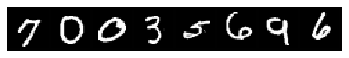

e 76, step 192000, loss 1.9507859945297241
Target:	 tensor([5, 2, 8, 7, 4, 9, 4, 4], device='cuda:0')
Pred:	 tensor([5, 2, 8, 7, 4, 9, 4, 4], device='cuda:0')


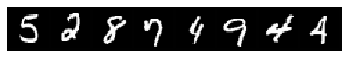

e 77, step 194000, loss 1.7771430015563965
Target:	 tensor([6, 1, 4, 1, 8, 9, 2, 8], device='cuda:0')
Pred:	 tensor([6, 1, 4, 1, 8, 9, 2, 8], device='cuda:0')


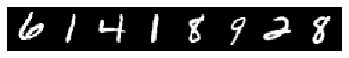

e 78, step 196000, loss 1.8054965734481812
Target:	 tensor([8, 4, 0, 1, 2, 4, 5, 7], device='cuda:0')
Pred:	 tensor([8, 4, 0, 1, 8, 4, 5, 7], device='cuda:0')


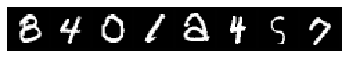

e 79, step 198000, loss 1.8468605279922485
Target:	 tensor([4, 9, 0, 5, 9, 0, 7, 3], device='cuda:0')
Pred:	 tensor([4, 7, 0, 5, 9, 0, 7, 3], device='cuda:0')


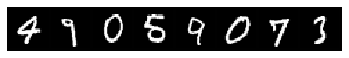

e 80, step 200000, loss 1.8777968883514404
Target:	 tensor([9, 9, 5, 9, 2, 0, 4, 0], device='cuda:0')
Pred:	 tensor([9, 9, 8, 9, 2, 0, 4, 0], device='cuda:0')


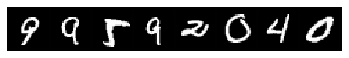

e 80, step 202000, loss 1.788085699081421
Target:	 tensor([6, 2, 1, 1, 0, 2, 7, 9], device='cuda:0')
Pred:	 tensor([6, 2, 1, 1, 0, 2, 7, 9], device='cuda:0')


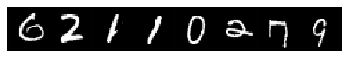

e 81, step 204000, loss 1.7849531173706055
Target:	 tensor([8, 1, 5, 4, 7, 6, 1, 6], device='cuda:0')
Pred:	 tensor([8, 1, 5, 4, 7, 6, 1, 6], device='cuda:0')


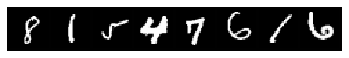

e 82, step 206000, loss 1.7800381183624268
Target:	 tensor([3, 6, 7, 4, 1, 1, 0, 5], device='cuda:0')
Pred:	 tensor([3, 6, 7, 4, 1, 1, 0, 5], device='cuda:0')


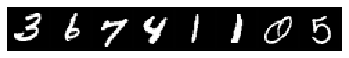

e 83, step 208000, loss 1.7869247198104858
Target:	 tensor([0, 7, 9, 8, 0, 5, 5, 7], device='cuda:0')
Pred:	 tensor([0, 7, 9, 8, 0, 5, 5, 7], device='cuda:0')


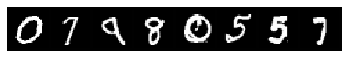

e 84, step 210000, loss 1.8137942552566528
Target:	 tensor([3, 8, 5, 6, 1, 7, 6, 6], device='cuda:0')
Pred:	 tensor([3, 8, 5, 6, 1, 7, 6, 6], device='cuda:0')


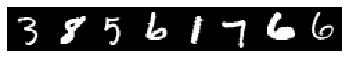

e 84, step 212000, loss 1.8026354312896729
Target:	 tensor([3, 7, 1, 6, 5, 8, 1, 5], device='cuda:0')
Pred:	 tensor([3, 7, 1, 6, 5, 8, 1, 5], device='cuda:0')


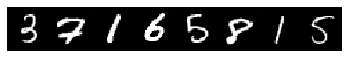

e 85, step 214000, loss 1.8075535297393799
Target:	 tensor([5, 1, 6, 4, 8, 0, 1, 2], device='cuda:0')
Pred:	 tensor([5, 1, 6, 4, 8, 0, 1, 2], device='cuda:0')


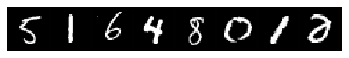

e 86, step 216000, loss 1.8540658950805664
Target:	 tensor([8, 4, 1, 7, 7, 6, 4, 1], device='cuda:0')
Pred:	 tensor([8, 9, 1, 7, 7, 6, 4, 1], device='cuda:0')


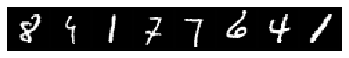

e 87, step 218000, loss 1.8800668716430664
Target:	 tensor([6, 6, 0, 3, 8, 5, 2, 2], device='cuda:0')
Pred:	 tensor([6, 6, 0, 3, 8, 5, 2, 2], device='cuda:0')


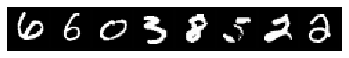

e 88, step 220000, loss 1.7870948314666748
Target:	 tensor([9, 7, 3, 5, 8, 7, 7, 0], device='cuda:0')
Pred:	 tensor([9, 7, 3, 5, 8, 7, 7, 0], device='cuda:0')


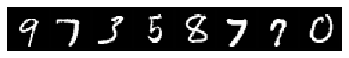

e 88, step 222000, loss 1.8001115322113037
Target:	 tensor([8, 9, 0, 4, 1, 1, 0, 3], device='cuda:0')
Pred:	 tensor([8, 9, 0, 4, 1, 1, 0, 3], device='cuda:0')


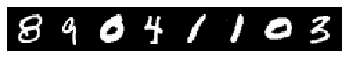

e 89, step 224000, loss 1.7815284729003906
Target:	 tensor([2, 5, 9, 4, 4, 0, 9, 3], device='cuda:0')
Pred:	 tensor([2, 5, 9, 4, 4, 0, 9, 3], device='cuda:0')


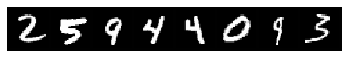

e 90, step 226000, loss 1.8692057132720947
Target:	 tensor([7, 9, 6, 5, 4, 2, 7, 1], device='cuda:0')
Pred:	 tensor([7, 9, 6, 5, 4, 2, 7, 1], device='cuda:0')


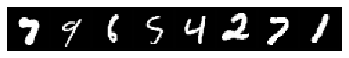

e 91, step 228000, loss 1.7200239896774292
Target:	 tensor([9, 7, 7, 1, 8, 6, 7, 4], device='cuda:0')
Pred:	 tensor([9, 7, 7, 1, 8, 6, 7, 4], device='cuda:0')


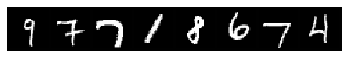

e 92, step 230000, loss 1.792433738708496
Target:	 tensor([6, 9, 5, 5, 9, 8, 7, 2], device='cuda:0')
Pred:	 tensor([6, 9, 5, 5, 9, 8, 7, 2], device='cuda:0')


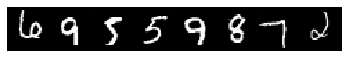

e 92, step 232000, loss 1.7548162937164307
Target:	 tensor([0, 8, 4, 1, 0, 1, 1, 7], device='cuda:0')
Pred:	 tensor([0, 8, 4, 1, 0, 1, 1, 7], device='cuda:0')


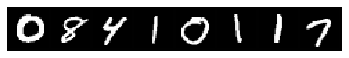

e 93, step 234000, loss 1.8704413175582886
Target:	 tensor([0, 4, 8, 7, 1, 3, 2, 0], device='cuda:0')
Pred:	 tensor([0, 4, 8, 7, 2, 3, 2, 0], device='cuda:0')


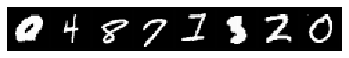

e 94, step 236000, loss 1.793448805809021
Target:	 tensor([0, 4, 2, 3, 1, 3, 1, 9], device='cuda:0')
Pred:	 tensor([0, 4, 2, 3, 1, 3, 1, 9], device='cuda:0')


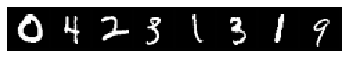

e 95, step 238000, loss 1.7790563106536865
Target:	 tensor([1, 3, 5, 3, 1, 3, 0, 5], device='cuda:0')
Pred:	 tensor([1, 3, 5, 3, 1, 3, 0, 5], device='cuda:0')


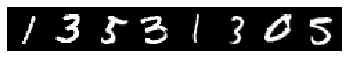

e 96, step 240000, loss 1.8358275890350342
Target:	 tensor([6, 6, 9, 6, 7, 6, 6, 0], device='cuda:0')
Pred:	 tensor([6, 6, 9, 6, 7, 6, 6, 0], device='cuda:0')


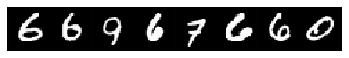

e 96, step 242000, loss 1.8352785110473633
Target:	 tensor([4, 5, 3, 4, 3, 3, 6, 0], device='cuda:0')
Pred:	 tensor([4, 5, 3, 4, 3, 3, 6, 0], device='cuda:0')


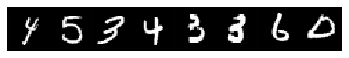

e 97, step 244000, loss 1.8189873695373535
Target:	 tensor([9, 8, 6, 4, 8, 8, 3, 7], device='cuda:0')
Pred:	 tensor([9, 8, 6, 4, 8, 8, 3, 7], device='cuda:0')


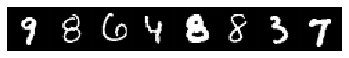

e 98, step 246000, loss 1.8110897541046143
Target:	 tensor([2, 6, 3, 9, 8, 9, 9, 1], device='cuda:0')
Pred:	 tensor([2, 6, 3, 9, 8, 9, 9, 1], device='cuda:0')


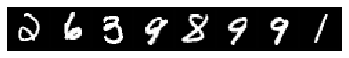

e 99, step 248000, loss 1.7869174480438232
Target:	 tensor([4, 0, 2, 5, 4, 2, 2, 2], device='cuda:0')
Pred:	 tensor([4, 0, 2, 5, 4, 2, 2, 2], device='cuda:0')


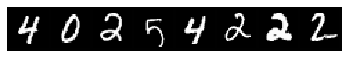

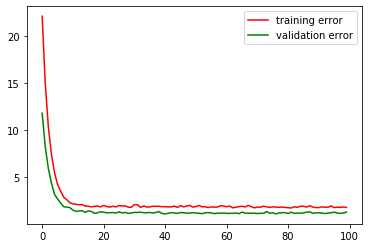

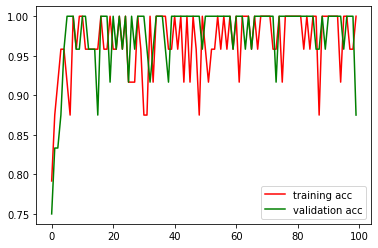

In [28]:
################################################################################################################################
# Training script
# learning rate, hyper-parameter
lr = 1e-3

# using GPU if it's availble
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

img_channel = 1
net = LeNetDropNorm(img_channel, device)
# keep a list of moel parameters
params = [p for (n, p) in net.named_parameters()]

# training epochs, hyper-parameter
epochs = 100

# keep tracking of the changing of loss and accuracy of predictions
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
print_interval = 2000
for e in range(epochs):
  net.train()
  for i, (imgs, lbs) in enumerate(train_dl):
    imgs = imgs.to(device)
    lbs = lbs.to(device)
    loss, prob = net(imgs, lbs)
     # add the weight decay penalty to the loss  
    lamb = 2.0   
    loss = weight_decay(loss, params, lamb, lbs.shape[0])
    
    net.zero_grad()
    grad = torch.autograd.grad(loss.to(device), params)
    
    # update weights
    lamb = 1
    step(params, grad, lr)
    
    # obtain the predictions
    pred = prob.argmax(dim=-1).view(batch_size)
    acc = (pred == lbs).float().mean()
    if (i + e*len(train_dl)) % print_interval == 0:
      print("e {}, step {}, loss {}".format( e, i + e*len(train_dl), loss))
      print("Target:\t {}\nPred:\t {}".format(lbs[:8], pred[:8]))
      # visualize some samples
      imgs_to_vis = vutils.make_grid(imgs[:8].cpu()+125., nrow=8, pad_value=1)
      plt.imshow(imgs_to_vis.permute(1,2,0).numpy().astype(np.uint8))
      plt.axis("off")
      plt.show()   
  train_loss_list.append(loss.detach().mean())
  train_acc_list.append(acc.detach().mean())
  
  net.eval()
  for i, (imgs, lbs) in enumerate(val_dl):
    imgs = imgs.to(device)
    lbs = lbs.to(device)
    loss, prob = net(imgs, lbs, training=False)
    # add the weight decay penalty to the loss  
    loss = weight_decay(loss, params, lamb, lbs.shape[0])   
    
    pred = prob.argmax(dim=-1).view(batch_size)
    acc = (pred == lbs).float().mean()
    
  val_loss_list.append(loss.detach().mean())
  val_acc_list.append(acc.detach().mean())
  

# ploting logs
plt.plot(np.arange(epochs), train_loss_list, '-r',
         np.arange(epochs), val_loss_list, '-g')
plt.legend(('training error', 'validation error'))
plt.show()
plt.plot(np.arange(epochs), train_acc_list, '-r',
         np.arange(epochs), val_acc_list, '-g')
plt.legend(('training acc', 'validation acc'))
plt.show()

## Submission

- Make sure you have finished all the required implementation tasks.
- Check your codes and make sure the result in each section could be reproducible.
- Upload the Jupyter file with all required figures plotted.
- Upload a pdf version of this Jupyter note. You can first download a html file by clicking on the Jupyter menu bar: File --> Download as --> HTML (.html). Then open the html file and convert it into a pdf file with your browser.